# 1 Author

**Student Name**: Desislava Kukova 
**Student ID**:  190480293  

# 2 Problem formulation

As described in [the MLEnd data sets GitHub page](https://mlenddatasets.github.io/yummy/), the MLEnd Yummy Dataset opens a window to our relationship as humans with food. The MLEnd Yummy Dataset is a collection of more than 3,000 enriched images from over 200 participants collected in 2023. Each picture was taken by a student and annotated by them with attributes such as dish name, home or restaurant, cuisine, ingredients, diet, healthiness rating and likeness rating.

As such, the problem that we formulate for the advanced component is:

**Given the picture taken of the food and the added annotations given by the student, can we predict the likeness rating given by the student?**

Interesting Aspects:
- The information is derived from multiple modalities - visual (the image) and textual (the annotations).
- Likeness ratings are subjective and based on individual preferences and perceptions. Understanding what makes a dish likeable involves capturing human perception nuances and could involve numerous factors such as visual appearance (the image) or cuisine, ingredients, and healthiness rating.
- The MLEnd data set is unique with specific enrichment, where the students provide both images and annotations to them with various attributes. Understing how the annotations contribute to predicting likability adds complexity.
- Could provide insights into dietary choices or cultural preferences.

# Preamble

In [1]:
# envrionment set up
!pip install --upgrade mlend

In [2]:
import mlend
from mlend import download_yummy, yummy_load

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
import glob

In [5]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [6]:
import cv2

In [7]:
import spkit as sp

In [8]:
from skimage.color import rgb2hsv, rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage import exposure
from skimage import feature

C:\Users\desik\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated


In [9]:
from scipy.stats import moment
from scipy.stats import randint

In [10]:
import string

In [11]:
from collections import Counter

In [12]:
import re

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [14]:
!pip install kneed

In [15]:
from kneed import KneeLocator

In [16]:
import networkx as nx

# 3 Machine Learning pipeline

MLYEnd Yummy Dataset - raw data

Data Collection and Preparation**

Exploration of the dataset.
Remove any missing values.
Categorise certain features.

**Output:** images with concise annotations

**Input:** The images

- **Image processing**

Resize images to standard format

**Output:** Processed images ready for feature extraction

**Input:** The processed images and concise annotations

- **Feature extraction and target values extraction**

Obtain features from the images: colour moments, GLCM and Hu moments features.
Obtain features from the annotations.
Encode target variable

**Output:** Feature and target arrays

**Input:** Feature and target arrays

- **Feature Reduction**

Feature reduction is performed through correlation threshold and pca.

**Output:** reduced feature matrix and pca transformed features 

**Input:** Specific problem, dataset and features

- **Model Selection**

**Output:** Specific machine learning models suitable for the problem, dataset and features: Linear Regresion, Random Forest Regressor, Gradient Boosting Regressor and Multi-layer Perception Regressor

**Input:** Feature and target arrays

- **Data splitting**

split the data into training, validation and testing subsets; pca transformed is only for Multi-layer Perception Regressor

**Output:** Train, validation and test subsets

**Input:** Train, validation and test subsets

-- **Feature scaling**

The train, validation and test subsets are scaled for models only for Multi-layer Perception Regressor.

**Output:** Scaled train, validation and test subsets

**Input:** Model and specific train set (scaled and pca transformed scaled only for Multi-layer Perception Regressor)

- **Model Training**

Train the model on the train subset

**Output:** Trained model

**Input:** Trained model and validation subset (scaled and pca transformed scaled only for Multi-layer Perception Regressor)

- **Validation and Tuning**

Validate the trained model on the validation subset and tune hyperparameters on the validation set.

**Output:** The better model out of the starting trained model or default model

**Input:** The better model and the test subset (scaled and pca transformed scaled only for Multi-layer Perception Regressor)

- **Model testing and Evaluation**

The better model is tested an evaluated in the test subset with specific evaluation metrics: mse, mae, r2, explained variance

**Output:** Evaluation metrics for the better model

**Input:** Evaluation metrics for the better models for all selected models

- **Model comparisson**

The trained and configured models are evaluated and compared on mse, mae, r2, explained variance

**Output:** The best performing model is chosen and ready for deployment

# 4 Transformation stage

In this section, the different transformations are described, input and output are identified as well as the rationale behind the transformation and an explanation of the implemented function.

## 4.1 Resizing stage

In this stage, we resize all images to ensure uniform size. Images of consistent size facilitate computational efficiency and ensure that the features extracted are comparable across different images.

Input: images (3D NumPy array with shape N x M x C)
Output: Resized image (NumPy array with shape size 224 x size 224 x C

**1st step - square the images**
Black colour is added to the images to square them to keep the original aspect ratio of each image.

In [17]:
def square_image(I, pad=0):
    """
    Square the input image by padding with a specified value.

    Parameters:
    - I: Input image (3D NumPy array with shape N x M x C).
    - pad: Value to use for padding (default is 0).

    Returns:
    - Square image (NumPy array with shape max(N, M) x max(N, M) x C).
    """

    N, M, C = I.shape
    if N > M:
        Is = [np.pad(I[:,:,i], [(0,0),(0, N-M)], 'constant', constant_values=pad) for i in range(C)]
    else:
        Is = [np.pad(I[:,:,i], [(0, M-N),(0,0)], 'constant', constant_values=pad) for i in range(C)]

    return np.array(Is).transpose([1, 2, 0])

**2nd step - Resize each picture to 224x224 pixels**
We have chosen this particular size due to its popularity for a good compromise between computational efficiency and capturing detailed features.

In [18]:
def resize_image(I, size=[224, 224]):
    """
    Resize the input image to a specified size.

    Parameters:
    - I: Input image (3D NumPy array with shape N x M x C).
    - size: Target size for resizing (default is [224, 224]).

    Returns:
    - Resized image (NumPy array with shape size[0] x size[1] x C).
    """

    N, M, C = I.shape
    Ir = [sp.resize(I[:,:,i], size) for i in range(C)]
    return np.array(Ir).transpose([1, 2, 0])

## 4.2 Feature Extraction from Image

### 4.2.1 Colour Moments

**Rationale:**

Colour moments (mean, variance, skewness) serve as statistical indicators, revealing insights into the colour distribution within an image. This information is valuable for capturing the overall colour tone and variability, potentially reflecting the ingredients employed in the dish.

Conversely, certain cetain colours could potentially contribute to predicitng the assosiatted likeness rating.

**Function Explanation:**

The function `colour_features` is designed to extract colour moments features for an RGB image. It focuses on capturing statistical attributes (mean, variance, skewness) for each channel red, green and blue.

In [19]:
def colour_features(I):
    """
    Extract colour moments features of an RGB image.

    Parameters:
    - I: Input RGB image (3D NumPy array with shape N x M x 3).

    Returns:
    - Colour moments features (mean_value, variance_value, skewness_value) for each channel.
    """

    # Convert RGB image to HSV colour space
    Ihsv = (rgb2hsv(I) * 255).astype('uint8')

    # Flatten the image for each channel
    flattened_channels = [I[:, :, i].flatten() for i in range(3)]

    # Compute colour moments for each channel
    moments_features = []
    for channel_values in flattened_channels:
        # Compute colour moments (mean, variance, skewness)
        mean_value = np.mean(channel_values)
        variance_value = np.var(channel_values)
        skewness_value = moment(channel_values, moment=3)

        moments_features.extend([mean_value, variance_value, skewness_value])

    return moments_features

### 4.2.2 Texture Features from Gray-Level Co-occurrence Matrix

**Rationale:**

Potentially, distinctive textual patterns could influence the likeness rating.


**Function Explanation:**

The function `GMLC_features` extracts Gray-Level Co-occurrence Matrix (GLCM) features from the grayscale version of an RGB image. The function prioritises texture information by converting the RGB image to grayscale by eliminating colour-related disparities. The extracted texture features, contrast, dissimilarity, correlation, homogeneity and energy provide valuable insights into the spatial relationships of pixel intensities.

In [20]:
def GLCM_features(I):
    """
    Extract Gray-Level Co-occurrence Matrix (GLCM) features: dissimilarity and correlation,
    from a grayscale version of an RGB image.

    Parameters:
    - I: Input RGB image (3D NumPy array with shape N x M x 3).

    Returns:
    - Five texture features: dissimilarity, correlation, homogeneity and energy
    """

    # Convert the image to grayscale
    Ig = (rgb2gray(I)*255).astype('uint8')
    
    # Compute the gray-level co-occurrence matrix
    glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,symmetric=True, normed=True)
    
    # Extracts texture features from GLCM
    contrast = graycoprops(glcm, 'contrast')[0, 0] 
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    
    return contrast, dissimilarity, correlation, homogeneity, energy

### 4.2.3 Hu Moments

**Rationale:**

Hu Moments, comprising seven scalar values, serve as valuable shape descriptors in image processing and pattern recognition. These moments are derived from central moments, statistical measures capturing the spatial distribution of intensity in an image. In the context of finding the likeness rating, it could capture essential shape features.

Hu Moment 1 (HU1) is invariant to translation changes and captures the overall scale or size of the object.<br>
Hu Moment 2 (HU2) is invariant to changes in scale and represents the rotationally invariant part of the shape.<br>
Hu Moment 3 (HU3) and Hu Moment 4 (HU4) are invariant to changes in rotation and capture the information related to the orientation or tilt of the object.<br>
Hu Moment 5 (HU5) is also invariant to changes in rotation and provides additional rotational information. <br>
Hu Moment 6 (HU6) and Hu Moment 7 (HU7) are invariant to changes in reflection and capture information related to whether the object is reflected or mirrored.

**Function Explanation:**

The function captures essential shape features. First, the RGB image is converted to grayscale. Then, the image moments are computed, and the Hu Moments are calculated based on them.

In [21]:
def extract_hu_moments(I):
    """
    Extract Hu Moments as shape features from an RGB image.

    Parameters:
    - I: Input RGB image (3D NumPy array with shape N x M x 3).

    Returns:
    - hu_moments_flat - Hu Moments (7 values)
    """

    # Convert the RGB image to grayscale
    Ig = (rgb2gray(I)*255).astype('uint8')

    # Compute Hu Moments
    moments = cv2.moments(Ig)
    hu_moments = cv2.HuMoments(moments)
    
    # Flatten the array
    hu_moments_flat = np.concatenate(hu_moments).flatten()

    return hu_moments_flat

## 4.3 Feature Extraction from Annotations

### 4.3.1 Healthiness Rating

**Rationale:**

If there is a correlation or relationship between healthiness and likeness, then a feature derived from healthiness ratings might capture some aspects that contribute to the overall appeal of a dish.

Healthiness could be a mediating factor influencing the overall perception of a dish. A dish perceived as healthy might be seen as less appealing and this influence could be captured in the likeness rating.

Interaction terms between healthiness feature and other features could highlight specific combinations that contribute to both likability.

**Function Explanation:**

Extract 'Healthiness_rating' column from a DataFrame, encode using label encoding and return a new DataFrame.

In [22]:
def extract_healthiness_ratings(df):
    """
    Extract 'Healthiness_rating' column from a DataFrame, encode using label encoding and return a new DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing the 'Healthiness_rating' column.

    Returns:
    - diet_encoded_df (DataFrame): New DataFrame with the encoded 'Healthiness rating' column.
    - label_mapping (dict): Mapping between original diet labels and their encoded values.
    """
    
    healthy = df['Healthiness_rating'].tolist()

    label_encoder = LabelEncoder()
    healthy_encoded = label_encoder.fit_transform(healthy)
    
    # Create a new DataFrame with the encoded 'healthy' column
    healthy_encoded_df = pd.DataFrame({'Healthiness Rating': healthy_encoded})

    # Mapping between original labels and encoded labels
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    return healthy_encoded_df, label_mapping

### 4.3.2 Diet

**Rationale:**

Including diet information (non-vegetarian, vegetarian, or vegan) as a feature for predicting likeness ratings can add a layer of personalization to the model, capturing individual and cultural preferences that may significantly influence the perceived appeal of dishes.

**Function Explanation:**

Extract 'Diet' column, encode using label encoding and return a new DataFrame.

In [23]:
def diet_labels(df):
    """
    Extract 'Diet' column from a DataFrame, encode using label encoding and return a new DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing the 'Diet' column.

    Returns:
    - diet_encoded_df (DataFrame): New DataFrame with the encoded 'Diet' column.
    - label_mapping (dict): Mapping between original diet labels and their encoded values.
    """
    
    diet = df['Diet'].tolist()

    label_encoder = LabelEncoder()
    diet_encoded = label_encoder.fit_transform(diet)
    
    # Create a new DataFrame with the encoded 'Diet' column
    diet_encoded_df = pd.DataFrame({'Diet': diet_encoded})

    # Mapping between original labels and encoded labels
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    return diet_encoded_df, label_mapping

### 4.3.3 Cuisine

**Rationale:**

Different cuisines are associated with distinct flavor profiles and ingredients. Likeness ratings can be influenced by individual or cultural preferences for certain cuisines. Affinity for specific cuisines could contribite to higher likeness.

**Function Explanation:**

Extract 'Cuisine_Category' column, encode using label encoding and return a new DataFrame.

In [24]:
def cuisine_labels(df):
    """
    Extract 'Cuisine_Category' column from a DataFrame, encode using label encoding and return a new DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing the 'Cuisine_Category' column.

    Returns:
    - cuisine_encoded_df (DataFrame): New DataFrame with the encoded 'Cuisine' column.
    - label_mapping (dict): Mapping between original diet labels and their encoded values.
    """
    
    cuisine = df['Cuisine_Category'].tolist()

    label_encoder = LabelEncoder()
    cuisine_encoded = label_encoder.fit_transform(cuisine)
    
    # Create a new DataFrame with the encoded 'Cuisine' column
    cuisine_encoded_df = pd.DataFrame({'Cuisine': cuisine_encoded})

    # Mapping between original labels and encoded labels
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    return cuisine_encoded_df, label_mapping

### 4.3.4 Ingredients

**Rationale:**

The variety or diversity of ingredients used, can be useful for predicting likeness ratings. Dishes with diverse ingredients could potentially offer a more complex flavour or be associated with certain cuisines that contribute to a higher likeness rating.

**Function Explanation:**

Count the number of ingredients and calculate the average length in the 'Ingredients' column and return a new Data Frame.

In [25]:
def count_ingredients(df):
    """
    Count the number of ingredients and calculate the average length
    in the 'Ingredients' column of a DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame.

    Returns:
    - a new Data Frame with columns Diversity and Average_ingredient_length
    """
    
    ingredient_lists = df['Ingredients'].apply(lambda x: str(x).split(','))

    # Count the number of ingredients
    ingredient_counts = np.array([len(ingredients) for ingredients in ingredient_lists])

    # Calculate the average length of ingredients
    avg_length = np.array([np.mean([len(ingredient) for ingredient in ingredients]) for ingredients in ingredient_lists])

    # Create a new DataFrame
    ingredient_df = pd.DataFrame({
        'Diversity': ingredient_counts,
        'Average ingredient length': avg_length
    })

    return ingredient_df

**Rationale:**

The presence of certain ingredients could potentially influence the likeness ratings. Dishes with certain ingredients could potentially have higher likeness ratings.

**Function Explanation:**

Create a DataFrame indicating the presence or absence of the top ingredients in 'Ingredients' column.

In [26]:
def ingredient_presence(df, num_top_words=50):
    """
    Create a DataFrame indicating the presence or absence of the top ingredients
    in the specified column of a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - num_top_words (int): Number of top words to consider. Default is 50.

    Returns:
    - pd.DataFrame: DataFrame with binary values (0 or 1),
                    where each column represents the presence or absence of a top ingredient.
    """
    all_ingredients = ' '.join(df['Individual Ingredients'].astype(str))

    # Count the occurrences of each word
    words = re.findall(r'\b\w+\b', all_ingredients.lower())
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(num_top_words)

    # Create a NumPy array with binary values for each word
    word_presence_array = np.zeros((len(df), num_top_words), dtype=int)

    # Iterate through the first N most common words
    for i, (word, _) in enumerate(most_common_words):
        # Check if the word is present in each 'Ingredients' entry
        word_presence_array[:, i] = df['Individual Ingredients'].str.contains(fr'\b{re.escape(word)}\b', case=False, regex=True).astype(int)

    # Create a DataFrame with column names from most_common_words
    ingredient_presence_df = pd.DataFrame(word_presence_array, columns=[word for word, _ in most_common_words])

    return ingredient_presence_df

### 4.3.5 Home context

**Rationale:**

Home-cooked dishes may have a different style of presentation and flavor profile compared to dishes prepared in a restaurant. The setting in which a dish is prepared can influence how it is perceived and rated for likability. Likeness ratings are often subjective and can be influenced by personal preferences. Some individuals may have a preference for homemade dishes due to associations with comfort and familiarity, while others may prefer restaurant-prepared dishes.

**Function Explanation:**

Extract 'Context_Category' column, encode using label encoding and return a new DataFrame.

In [27]:
def home_labels(df):
    """
    Extract 'Context_Category' column from a DataFrame, encode using label encoding and return a new DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing the 'Context_Category' column.

    Returns:
    - context_encoded_df (DataFrame): New DataFrame with the encoded 'Context' column.
    - label_mapping (dict): Mapping between original diet labels and their encoded values.
    """
    
    context = df['Context_Category'].tolist()

    label_encoder = LabelEncoder()
    context_encoded = label_encoder.fit_transform(context)
    
    # Create a new DataFrame with the encoded 'Context' column
    context_encoded_df = pd.DataFrame({'Context': context_encoded})

    # Mapping between original labels and encoded labels
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    return context_encoded_df, label_mapping

# 5 Modelling

In this section the chosen models are described and the rationale behind the choice is given.

Given the goal is to predict the likeness rating based on features extracted from images and additional annotations provided by students, the problem is approached ad a regression task as regression models are suitable for predicting continuous values.

## 5.1 Linear Regression

**Rationale for choosing this particular model:**

- simple and easy to intepret model
- good starting point to establish baseline

## 5.2 Random Forest Regressor

**Rationale for choosing this particular model:**
- An ensemble learning method, builds multiple decision trees and combines their predictions, resulting in more robust and acurate predictions compared to individual trees
- Capable of capturing non-linear relationships
- Capable of handling high-dimensional data
- Handles imbalanced data well and prevents bias towards the majority class
- Provides feature importance score
- Robust to overfitting
- Tunining flexibility
- Generalises well to new data

## 5.3 Gradient Boosting Regressor

**Rationale for choosing this particular model:**
- An ensemble learning method, builds a series of weak learners sequentially, and each new tree corrects the errors of the combined ensemble
- Capable of capturing non-linear relationships
- Robust to outliers
- Provides feature importance score
- Robust to overfitting with adaptive learning rate
- Tunining flexibility
- Generalises well to new data

## 5.4 Multi-layer Perceptron Regressor

**Rationale for choosing this particular model:**

- Designed specifically for regression problems
- Capable of learning complex and non-linear relationships in data
- Capable of capturing intricate interactions between input feeatures due to multiple layers of interconnected nodes
- Flexibility to adapt to different types of data distributions

# 6 Methodology

In this section, the methodology for each model is given.

## 6.1  Linear Regression

**Data Splitting**
Train-Validation-Test Split with split ratio 70-15-15 and ensure that each set maintains the same class distribution as the original.

**Model Training**
Train the linear regression model with default parameters on the training set to learn optimal weights for the features.

**Validation and Hyperparameter Tuning**
Perform grid search with 5-fold cross-validation and use the MSE as evaluation metric.<br>
Mean Squared Error (MSE) is the average of the squared differences between the predicted and actual values and is used because it  penalises large errors more heavily.<br>
Tune hyperparameters for linear regression:<br>
fit_intercept - the choice whether to calculate the intercept for the model.<br>
positive - the choice whether to force the coefficients to be positive.<br>
Choose model by asssesing performance through MSE, MAE, R2.

**Model Evaluation**
Evaluate the chosen model on the test set.
Assess the model performance through scatter plot and evaluation metrics MSE, MAE, R2

## 6.2 Random Forest Regressor

**Data Splitting**
Train-Validation-Test Split with split ratio 70-15-15 and ensure that each set maintains the same class distribution as the original.

**Model Training**
Train the model on the training set with default hyperparameters.

**Validation and Hyperparameter Tuning**
Perform randomised search with 5-fold cross-validation and use the MSE as evaluation metric.<br>
Mean Squared Error (MSE) is the average of the squared differences between the predicted and actual values and is used because it  penalises large errors more heavily.<br>
Tune hyperparameters for RF:<br>
n_estimators - number of trees in the forest; <br>
max_depth - maximum depth of the trees;<br>
min_samples_split - minimum number of samples required to split an internal node;<br>
min_samples_leaf - minimum number of samples required to be at a leaf node. Higher values tend to prevent overfitting;<br>
max_features - the number of features to consider when looking for the best split.<br>
Choose model by asssesing performance through MSE, MAE, R2.

**Model Evaluation**
Evaluate the chosen model on the test set.
Assess the model performance through scatter plot and evaluation metrics MSE, MAE, R2

## 6.3 Gradient Boosting Regressor

**Data Splitting**
Train-Validation-Test Split with split ratio 70-15-15 and ensure that each set maintains the same class distribution as the original.

**Model Training**
Train the model on the training set with default hyperparameters.

**Validation and Hyperparameter Tuning**
Perform randomised search with 5-fold cross-validation and use the MSE as evaluation metric.<br>
Mean Squared Error (MSE) is the average of the squared differences between the predicted and actual values and is used because it  penalises large errors more heavily.<br>
Tune hyperparameters for GB:<br>
n_estimators - number of trees in the forest; <br>
learning_rate - shrinks the contribution of each tree by learning_rate; <br>
max_depth - maximum depth of the trees;<br>
min_samples_split - minimum number of samples required to split an internal node;<br>
min_samples_leaf - minimum number of samples required to be at a leaf node. Higher values tend to prevent overfitting;<br>
subsample - the fraction of samples to be used for fitting the individual base learners;<br>
max_features - the number of features to consider when looking for the best split.<br>
Choose model by asssesing performance through MSE, MAE, R2.

**Model Evaluation**
Evaluate the chosen model on the test set.
Assess the model performance through scatter plot and evaluation metrics MSE, MAE, R2

## 6.4 Multi-layer Perceptron Regressor

**Data Splitting**
Train-Validation-Test Split with split ratio 70-15-15 and ensure that each set maintains the same class distribution as the original.

**Feature Scaling**
Feature Scaling Perform normalisation on the features

**Model Training**
Train the model on the training set with default hyperparameters.

**Validation and Hyperparameter Tuning**
Perform grid search with 5-fold cross-validation and use the MSE as evaluation metric.<br>
Mean Squared Error (MSE) is the average of the squared differences between the predicted and actual values and is used because it  penalises large errors more heavily.<br>
Tune hyperparameters for MLP Regressor:<br>
hidden_layer_sizes - determines the architexture of the neural network;
activation - specifies the activation function for the hidden layers;
alpha - regularisation parameter that penalises large weights to prevent overfitting;
learning_rate - specifies how the learning rate is adapted during training.
Choose model by asssesing performance through MSE, MAE, R2.

**Model Evaluation**
Evaluate the chosen model on the test set.
Assess the model performance through scatter plot and evaluation metrics MSE, MAE, R2

# 7 Dataset

In this section the dataset used to create and validate the models is described.

We would use the MLEnd Yummy Dataset to create our models and validate them.

The MLEnd Yummy Dataset is a collection of more than 3,000 enriched images from over 200 participants collected in 2023. The images contain pictures of different dishes and each picture is annotated with attributes such as dish name, home or restaurant, cuisine, ingredients, diet, healthiness rating and likeness rating.

## 7.1 Gathering the dataset for the defined problem

Firstly, the datset is downloaded and checked that is available for use - there should be 3250 images.

In [28]:
subset = {}

datadir = download_yummy(save_to = r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd', subset = subset,verbose=1,overwrite=False)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


The contents of the folder where the MLEnd Dataset is saved are checked.

In [29]:
os.listdir(datadir)

['MLEndYD_images', 'MLEndYD_image_attributes_benchmark.csv']

The file `MLEndYD_image_attributes_benchmark.csv` which contains dataset information is saved to a variable and the name of the image is used as an index.

In [30]:
MLENDYD_df = pd.read_csv( r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd\yummy\MLEndYD_image_attributes_benchmark.csv').set_index('filename')
print("Shape of the DataFrame:", MLENDYD_df.shape)
MLENDYD_df.head()

Shape of the DataFrame: (3250, 11)


,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train


Now we would check if it the downloaded images and the described images are the same size and whether there is a picture without a description or a discription without a picture.

In [31]:
# Get the list of downloaded image files
sample_path = r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd\yummy\MLEndYD_images\*.jpg'
files = glob.glob(sample_path)

# Extract the image names from the file paths
file_names = [file.split('\\')[-1] for file in files]

# Get the index of MLENDYD_df
df_names = MLENDYD_df.index

# Find images present in the MLENDYD_df but not in the downloaded files
missing_in_downloaded = set(df_names) - set(file_names)

# Find images present in the downloaded files but not in the MLENDYD_df
missing_in_df = set(file_names) - set(df_names)

# Display the results
if len(missing_in_downloaded) == 0 and len(missing_in_df)==0:
    print('The downloaded images and the images annotated in MLENDYD_df are the same.')
else:
    print("Number of Images Missing in Downloaded Files:", len(missing_in_downloaded))
    print("Images Missing in Downloaded Files:", missing_in_downloaded)
    print()
    print("\nNumber of Images Missing in DataFrame:", len(missing_in_df))
    print("Images Missing in DataFrame:", missing_in_df)

The downloaded images and the images annotated in MLENDYD_df are the same.


Check for any missing values in the entire dataframe

In [32]:
# Check if there are any missing values in the entire DataFrame
any_missing = MLENDYD_df.isnull().sum().any()

if any_missing:
    # Display the columns with missing values and their counts
    missing_values = MLENDYD_df.isnull().sum()
    print("Missing Values in Each Column:")
    print(missing_values[missing_values > 0])
else:
    print("There are no missing values in the DataFrame.")

Missing Values in Each Column:
Cuisine_org               5
Cuisine                   5
Healthiness_rating        1
Healthiness_rating_int    1
Likeness                  4
Likeness_int              4
dtype: int64


Remove rows with missing values:

In [33]:
MLENDYD_df = MLENDYD_df.dropna()

print("Shape of the Cleaned DataFrame:", MLENDYD_df.shape)

Shape of the Cleaned DataFrame: (3241, 11)


All strings in all columns of MLENDYD_df are to be coverted to lowercase.

In [34]:
MLENDYD_df = MLENDYD_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

The character sequence "\n" representing a newline, and the special characters without "," and "_" are to be removed from Ingredients.

Asumption: "_" would keep the expressions together and "," would keep the different expressions separate

In [35]:
MLENDYD_df['Ingredients'] = MLENDYD_df['Ingredients'].str.replace("\n", ",")

special_characters = string.punctuation.replace(",", "").replace("_", "")
for char in special_characters:
    MLENDYD_df['Ingredients'] = MLENDYD_df['Ingredients'].str.replace(char, ",")

C:\Users\desik\AppData\Local\Temp\ipykernel_21824\2513762230.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


Thus the gathering of the dataset representative of the problem is completed.

## 7.2 Data Exploration and Preporcessing

The unique values for column `Cuisine` are displayed as well as their distribution.

In [36]:
unique_cuisines = sorted(MLENDYD_df['Cuisine'].unique())

distribution = MLENDYD_df['Cuisine'].value_counts()

print("Unique Cuisines:")
print(unique_cuisines)

print("\nCuisine Distribution:")
distribution

Unique Cuisines:
['afghan', 'african', 'american', 'american_italian', 'american_mexican', 'arab', 'arab_spanish', 'argentina', 'asian', 'asian_fusion', 'australian', 'austrian', 'azeri', 'bangladeshi', 'belgian', 'bengali', 'berber', 'brazilian', 'british', 'bulgarian', 'canadian', 'caribbean', 'chettinad', 'chinese', 'colombian', 'colombian ', 'continental', 'cuban', 'danish', 'dutch', 'east_indian', 'eastern_mediterranean', 'egyptian', 'english', 'european', 'fast_food', 'french', 'fruit', 'fusion', 'general', 'german', 'german_turkish', 'ghanian', 'global', 'global_culinary', 'goan_international', 'greek', 'gujarati', 'hungarian', 'hybird', 'hyderabadi_indian', 'indian', 'indian_british', 'indian_mix_match', 'indian_snack', 'indian_thai_fusion', 'indo_chinese', 'indo_italian', 'indo_turkish', 'indonesian', 'international', 'iranian', 'italian', 'jamaican', 'japanese', 'jordan', 'karnataka', 'kenyan', 'kerala', 'korean', 'latin_fusion', 'lebanese', 'lebanese_palestinian', 'levantine

indian            1103
chinese            343
italian            283
american           252
british            203
                  ... 
bengali              1
vegan                1
indo_turkish         1
levantine            1
german_turkish       1
Name: Cuisine, Length: 128, dtype: int64

The cuisines are too versetile and would be mapped into categories. The distribution of the new categories is displayed.

In [37]:
# Mapping of cuisines to categories
cuisine_mapping = {
    'African': ['african', 'berber', 'ghanian', 'kenyan', 'madeiran', 'nigerian', 'somali', 'south_african', 'sudan', 'zimbabwean'],
    'American': ['american', 'american_italian', 'canadian', 'fast_food', 'international'],
    'South_American': ['argentina','brazilian', 'caribbean', 'colombian', 'colombian ', 'cuban', 'jamaican', 'latin_fusion', 'peruvian', 'south_american'],
    'Asian': ['asian', 'bangladeshi', 'indo_chinese', 'indo_italian', 'indonesian', 'malaysian', 'nepalese', 'panasian', 'russian', 'singaporean', 'south_asian', 'srilankan', 'taiwan_chinese', 'taiwanese', 'thai', 'tibetan', 'uzbek', 'vietnamese'],
    'British': ['british', 'scottish', 'english'],
    'Chineese': ['chinese', 'sichuan'],
    'Continental': ['continental', 'austrian', 'azeri', 'belgian', 'danish', 'dutch', 'european', 'german', 'hungarian', 'nordic', 'norwegian', 'polish', 'swiss', 'western'],
    'French': ['french'],
    'Indian': ['indian', 'indian bengali', 'chettinad', 'east_indian', 'goan_international', 'gujarati', 'hyderabadi_indian', 'indian_british', 'indian_snack', 'indian_thai_fusion', 'karnataka', 'kerala', 'mughali', 'north_indian', 'noth_indian', 'punjabi', 'south_indian', 'udupi'],
    'Italian': ['italian'],
    'Japanese': ['japanese'],
    'Korean': ['korean'],
    'Mediterranean': ['mediterranean', 'bulgarian', 'greek', 'eastern_mediterranean', 'spanish'],
    'Mexican': ['mexican', 'mexican_international', 'american_mexican'],
    'Middle_Eastern': ['middle_eastern', 'jordan', 'arab', 'arab_spanish', 'lebanese', 'lebanese_palestinian', 'afghan', 'egyptian', 'levantine', 'libyan', 'iranian', 'middle_east_turkish', 'morrocan', 'persian', 'saudi_arabian'],
    'Pakistani': ['pakistani'],
    'Portuguese': ['portuguese', 'portuguese_and_british_culture'],
    'Turkish': ['turkish', 'german_turkish', 'indo_turkish'],
}

# Function to map cuisine to category
def map_cuisine_to_category(cuisine):
    for category, cuisines_list in cuisine_mapping.items():
        if cuisine.lower() in cuisines_list:
            return category
    return 'Other'

MLENDYD_df['Cuisine_Category'] = MLENDYD_df['Cuisine'].apply(map_cuisine_to_category)

unique_cuisines = sorted(MLENDYD_df['Cuisine_Category'].unique())

distribution = MLENDYD_df['Cuisine_Category'].value_counts()

print("\nCuisine Categories Distribution:")
distribution


Cuisine Categories Distribution:


Indian            1208
Chineese           344
British            305
Italian            283
American           278
Asian              143
Continental        103
Middle_Eastern      82
Japanese            71
Turkish             60
French              55
Mediterranean       55
Pakistani           50
Mexican             47
Other               40
Korean              37
African             33
Portuguese          30
South_American      17
Name: Cuisine_Category, dtype: int64

The unique values for column `Home_or_restaurant` are displayed as well as their distribution.

In [38]:
unique_cuisines = sorted(MLENDYD_df['Home_or_restaurant'].unique())

distribution = MLENDYD_df['Home_or_restaurant'].value_counts()

print("Unique Home_or_restaurant:")
print(unique_cuisines)

print("\nHome_or_restaurant Distribution:")
distribution

Unique Home_or_restaurant:
['36_street_food', 'afghan_grill', 'albura_kathisma_bistro', 'aldi', 'ambala', 'anjappar_restaurant', 'antalya_restaurant', 'asda', 'bamboo', 'bananatree', "bill's", 'biryani_house', 'broasto', 'bui_vien', 'buns_&_berries', 'burgasum', 'burger_&_beyond', 'burger_and_chop', 'burgitzza_watford', 'cafe_de_nata', 'cake_box', 'canting', 'capital_restaurant', 'chengdufu', 'chicken_shop', 'chicken_world', 'chinese_supermarket', 'chongqing_old_street', 'co-op', 'coco_di_mama', 'costa', 'curve', 'dalchini', 'dandan_noodle_restaurant', 'dartmoor_lodge', 'dashi_chazuke', 'delamina_east', 'desi_lounge', 'dominos', 'domino’s', 'eat_tokyo', 'efes', 'efes_restaurant', "emilia's_crafted_pasta", 'eminonu_borekcisi', 'emirates_restaurant', 'erhan', 'fanzy', 'farmer.j', "ferrari's", 'five_guys', 'five_guys_watford', 'flames', 'flat_iron', 'fortitude_bakehouse', 'fried_&_grilled', 'gdk', 'german_doner_kebab', 'german_doner_kebab_watford', 'gindaco', 'gonpachi', 'goodfellas', 'gr

home                                 2232
restaurant                            504
resturant                              18
the_curve                              15
homemade                               13
                                     ... 
restaurant(the_curve_-_starbucks)       1
nando's_euston_station                  1
hiba_restraunt                          1
goodfellas                              1
canting                                 1
Name: Home_or_restaurant, Length: 215, dtype: int64

The cuisines are too versetile and would be mapped into categories. The distribution of the new categories is displayed.``

The values for `Home_or_restaurant` are too versetile adnd would be mapped into categories. The distribution of the new categories is displayed.

In [39]:
# Mapping of cuisines to categories
home_mapping = {'Home': ['home','home_(hellofresh)', 'homemade',]}

# Function to map home or restaurant to category
def map_home_to_category(cuisine):
    for category, cuisines_list in home_mapping.items():
        if cuisine.lower() in cuisines_list:
            return category
    return 'Restaurant'

MLENDYD_df['Context_Category'] = MLENDYD_df['Home_or_restaurant'].apply(map_home_to_category)

unique_cuisines = sorted(MLENDYD_df['Context_Category'].unique())

distribution = MLENDYD_df['Context_Category'].value_counts()

print("\nContext Categories Distribution:")
distribution


Context Categories Distribution:


Home          2248
Restaurant     993
Name: Context_Category, dtype: int64

Exploration of the most common Ingredients:

In [40]:
MLENDYD_df['Individual Ingredients'] = MLENDYD_df['Ingredients'].str.replace("_", ",")

numeric_characters = '0123456789'
for char in numeric_characters:
    MLENDYD_df['Individual Ingredients'] = MLENDYD_df['Individual Ingredients'].str.replace(char, " ") 

all_ingredients = ' '.join(MLENDYD_df['Individual Ingredients'].astype(str))

words = re.findall(r'\b\w+\b', all_ingredients.lower())

word_counts = Counter(words)

most_common_words = word_counts.most_common()

print("Top 10 Most Common Words in Ingredients:")
for word, count in most_common_words[:10]:
    print(f"{word}: {count}")

Top 10 Most Common Words in Ingredients:
oil: 1389
salt: 1294
powder: 1243
onion: 922
garlic: 830
rice: 804
chicken: 787
tomato: 691
chilli: 686
pepper: 630


The number of pictures for each class is calculated. The MLENDYD_df contains a column `Likeness_int` which represents the likeness rating as an integer.

In [41]:
class_counts = MLENDYD_df['Likeness_int'].value_counts()
print("Number of Pictures for Each Class:")
print(class_counts)

Number of Pictures for Each Class:
5.0    1394
4.0    1187
3.0     450
2.0     163
1.0      47
Name: Likeness_int, dtype: int64


The bar chart below displays the likeness rating distribution in the dataset. It displays the number of images labeled with different likeness ratings. The height of each bar represents the count of images for the corresponding class.

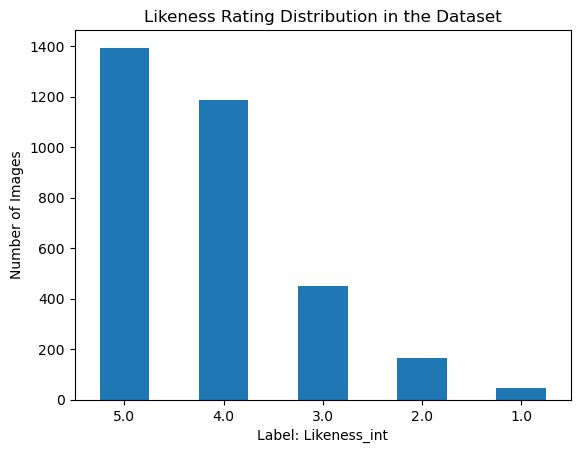

In [42]:
class_counts.plot(kind='bar', rot=0)
plt.xlabel('Label: Likeness_int')
plt.ylabel('Number of Images')
plt.title('Likeness Rating Distribution in the Dataset')
plt.show()

The 1.0  and 2.0 classes are significantly outnumbered by the 5.0 and 4.0 class, thus resulting in an imbalanced set.

Three pictures from the MLENDYD_df would be visualised for each class.

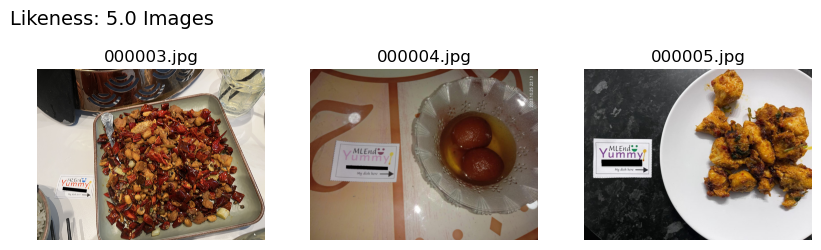

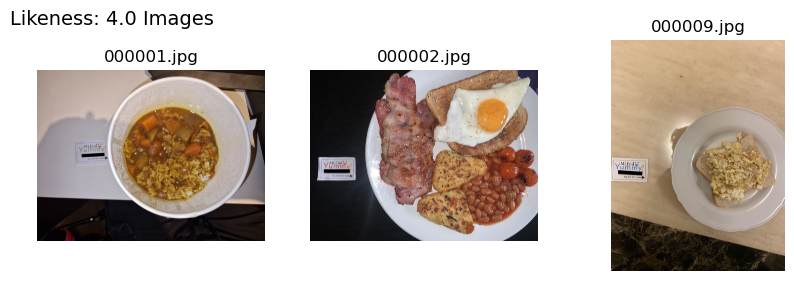

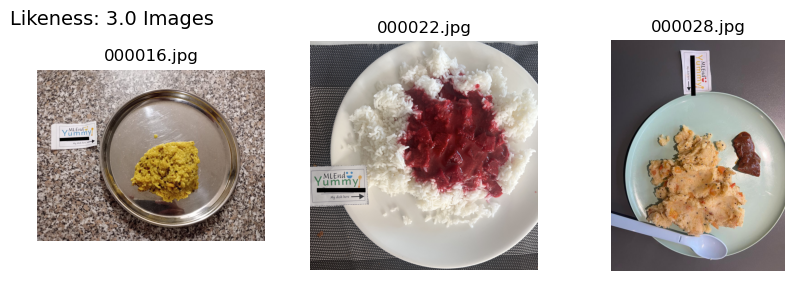

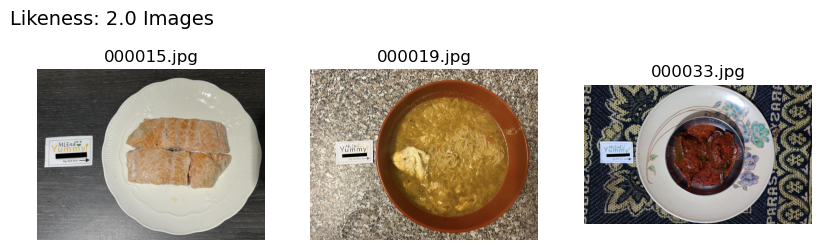

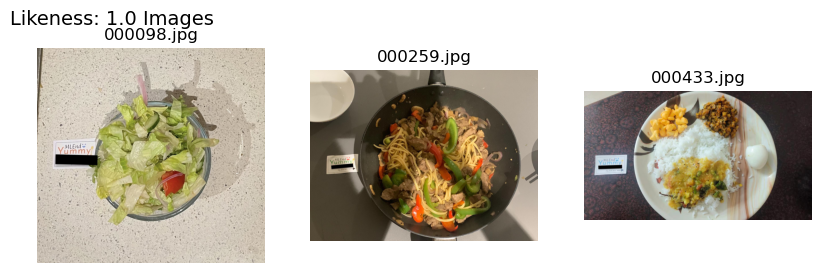

In [43]:
image_directory = r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd\yummy\MLEndYD_images'

# Filter images for classes
five_images = MLENDYD_df[MLENDYD_df['Likeness_int'] == 5.0].index[:3]
four_images = MLENDYD_df[MLENDYD_df['Likeness_int'] == 4.0].index[:3]
three_images = MLENDYD_df[MLENDYD_df['Likeness_int'] == 3.0].index[:3]
two_images = MLENDYD_df[MLENDYD_df['Likeness_int'] == 2.0].index[:3]
one_images = MLENDYD_df[MLENDYD_df['Likeness_int'] == 1.0].index[:3]

# Function to display images
def display_images(image_paths, title):
    plt.figure(figsize=(10, 3))
    plt.suptitle(title, fontsize=14, x=0.2)
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, 3, i + 1)
        img = plt.imread(os.path.join(image_directory, img_path))
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_path)

display_images(five_images, 'Likeness: 5.0 Images')
display_images(four_images, 'Likeness: 4.0 Images')
display_images(three_images, 'Likeness: 3.0 Images')
display_images(two_images, 'Likeness: 2.0 Images')
display_images(one_images, 'Likeness: 1.0 Images')
plt.show()

As the images are of different sizes, there is the need to uniform them.

In [44]:
image_directory = r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd\yummy\MLEndYD_images'
Images = []

for k, (_, row) in enumerate(MLENDYD_df.iterrows()):
    I =plt.imread(os.path.join(image_directory, row.name))
    I = square_image(I, pad=0)
    I = resize_image(I, size=[224, 224])
    Images.append(I)
    sp.utils.ProgBar_JL(k, len(MLENDYD_df), L=50, color='blue')

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3241\3241|
Done!


The shape of Images is checked.

In [45]:
Images = np.array(Images)
Images.shape

(3241, 224, 224, 3)

The first 10 resized images are displayed.

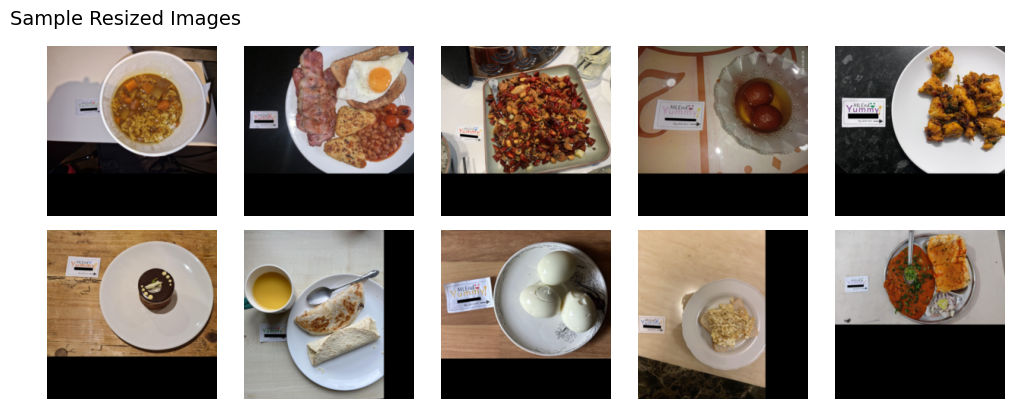

In [46]:
# Display the first 10 pitcures that were resized
plt.figure(figsize=(10,6))
for k,I in enumerate(Images):
    plt.subplot(3,5,k+1)
    plt.imshow(I)
    plt.axis('off')
    k+=1
    if k>=10:break
plt.suptitle('Sample Resized Images', fontsize=14, x=0.1)
plt.tight_layout()
plt.show()

## 7.3 Prediction Values

The first image from MLENDYD_df is displayed before resizing. The filename, dish name, given label and dimensions are also displayed.

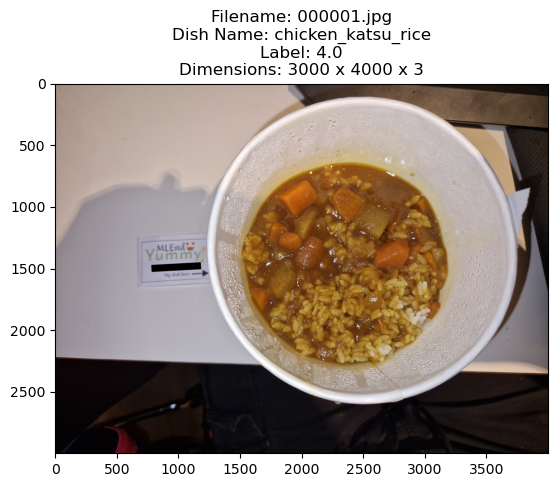

In [47]:
first_row = MLENDYD_df.iloc[0]
# Extract information from the row
filename = first_row.name
dish_name = first_row['Dish_name']
label = first_row['Likeness_int']

image_directory = r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd\yummy\MLEndYD_images'
img = plt.imread(os.path.join(image_directory, filename))
plt.imshow(img)
height, width, channels = img.shape
plt.title(f"Filename: {filename}\nDish Name: {dish_name}\nLabel: {label}\nDimensions: {height} x {width} x {channels}")
plt.show()

For each image, the label and file name is extracted. The label is also encoded and its map is displayed. The classification and the encoded classification is shown for the first few images.

In [48]:
y = []
filenames = []

for index, row in MLENDYD_df.iterrows():
    y.append(row['Likeness_int'])
    filenames.append(index)
    
# Convert lists to NumPy arrays
y = np.array(y)
filenames = np.array(filenames)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print('Label Mapping:')
for label, encoded_label in label_mapping.items():
    print(f'{label}: {encoded_label}')
    
y_df = pd.DataFrame({'filenames': filenames, 'y': y, 'y_encoded': y_encoded})
y_df.head()

Label Mapping:
1.0: 0
2.0: 1
3.0: 2
4.0: 3
5.0: 4


,filenames,y,y_encoded
0,000001.jpg,4.0,3
1,000002.jpg,4.0,3
2,000003.jpg,5.0,4
3,000004.jpg,5.0,4
4,000005.jpg,5.0,4


## 7.4 Feature Extraction

### 7.4.1 Image Features
The first image from Images and its dimensions are displayed.

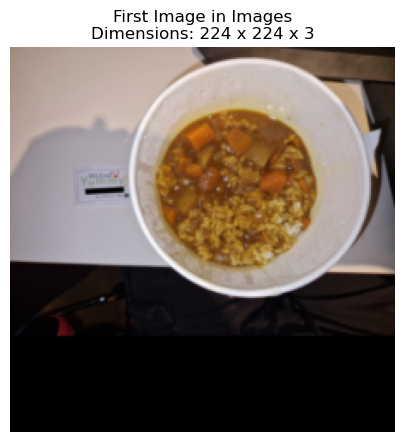

In [49]:
plt.figure(figsize=(5,5))
plt.imshow(Images[0])
height, width, channels = Images[0].shape
plt.title(f"First Image in Images\nDimensions: {height} x {width} x {channels}")
plt.axis('off')
plt.show()

For the first image from Images the features described in section 4.2 Feature Extraction are extracted and displayed.

In [50]:
print('Extracted features for the first image from Images\n')

print('Features from Colour Moments:')
f0, f1, f2, f3, f4, f5, f6, f7, f8 = colour_features(Images[0])
print(f'   The mean value of channel Red is {f0}')
print(f'   The varience value of channel Red is {f1}')
print(f'   The skewness value of channel Red is {f2}')
print(f'   The mean value of channel Green is {f3}')
print(f'   The varience value of channel Green is {f4}')
print(f'   The skewness value of channel Green is {f5}')
print(f'   The mean value of channel Blue is {f6}')
print(f'   The varience value of channel Blue is {f6}')
print(f'   The skewness value of channel Blue is {f8}\n')

print('Texture Features from Gray-Level Co-occurrence Matrix:')
f9, f10, f11, f12, f13 = GLCM_features(Images[0])
print(f'   The contrast is {f9}')
print(f'   The dissimilarity is {f10}')
print(f'   The correlation is {f11}')
print(f'   The homogeneity is {f12}')
print(f'   The energy is {f13}\n')

print('Features from Hu Moments:')
f14, f15, f16, f17, f18, f19, f20 = extract_hu_moments(Images[0])
print(f'   Translation Invariance\n      HU1 is {f14}')
print(f'   Scale Invarience\n      HU2 is {f15}')
print(f'   Rotation Invarience\n      HU3 is {f16}\n      HU4 is {f17}\n      HU5 is {f18}')
print(f'   Reflection Invarience\n      HU6 is {f19}\n      HU7 is {f20}')

Extracted features for the first image from Images

Features from Colour Moments:
   The mean value of channel Red is 0.3900800171314334
   The varience value of channel Red is 0.10646858547538086
   The skewness value of channel Red is -0.0025818854902570727
   The mean value of channel Green is 0.3389154079328829
   The varience value of channel Green is 0.0920264882143071
   The skewness value of channel Green is 0.0038009437465024447
   The mean value of channel Blue is 0.30141027175200247
   The varience value of channel Blue is 0.30141027175200247
   The skewness value of channel Blue is 0.011333126708690565

Texture Features from Gray-Level Co-occurrence Matrix:
   The contrast is 620.0181833007175
   The dissimilarity is 10.884703196347033
   The correlation is 0.9492247128211775
   The homogeneity is 0.39716825170611486
   The energy is 0.2477018264591759

Features from Hu Moments:
   Translation Invariance
      HU1 is 0.0012772498865315676
   Scale Invarience
      HU2 is 2.

For each image, the above features are extracted. The exctracted features are displayed for the first few images.

In [51]:
Ximage = []

for image in Images:
    # Feature extraction
    colour_features_result = colour_features(image)
    glcm_features_result = GLCM_features(image)
    hu_moments_result = extract_hu_moments(image)

    # Concatenate all features into a single array
    features = np.concatenate([
        colour_features_result,
        glcm_features_result,
        hu_moments_result
    ])

    # Append features to Ximage
    Ximage.append(features)

# Convert list to NumPy arrays
Ximage = np.array(Ximage)

column_names = ['Red channel mean', 'Red channel varience', 'Red channel skewness',
                'Green channel mean', 'Green channel varience', 'Green channel skewness',
                'Blue channel mean', 'Blue channel varience', 'Blue channel skewness',
                'GLCM contrast', 'GLCM dissimilarity', 'GLCM correlation', 'GLCM homogeneity', 'GLCM energy',
                'HU1 - Translation Invariance', 'HU2 - Scale Invarience',
                'HU3 - Rotation Invarience', 'HU4 - Rotation Invarience', 'HU5 - Rotation Invarience',
                'HU6 - Reflection Invarience', 'HU7 - Reflection Invarience' ]
image_feature_df = pd.DataFrame(Ximage, columns=column_names)

image_feature_df.head()

,Red channel mean,Red channel varience,Red channel skewness,Green channel mean,Green channel varience,Green channel skewness,Blue channel mean,Blue channel varience,Blue channel skewness,GLCM contrast,...,GLCM correlation,GLCM homogeneity,GLCM energy,HU1 - Translation Invariance,HU2 - Scale Invarience,HU3 - Rotation Invarience,HU4 - Rotation Invarience,HU5 - Rotation Invarience,HU6 - Reflection Invarience,HU7 - Reflection Invarience
0,0.390080,0.106469,-0.002582,0.338915,0.092026,0.003801,0.301410,0.092457,0.011333,620.018183,...,0.949225,0.397168,0.247702,0.001277,2.847228e-07,5.889611e-13,7.952757e-12,1.642866e-23,2.182098e-15,5.131894e-24
1,0.365036,0.108463,0.003856,0.300269,0.087361,0.014767,0.272613,0.084741,0.022659,1195.401235,...,0.896826,0.377979,0.246685,0.001288,3.093092e-08,1.349870e-10,1.194109e-11,1.046187e-22,1.955076e-15,4.678609e-22
2,0.393935,0.099344,0.005484,0.319019,0.094516,0.017853,0.267200,0.085803,0.022451,1360.177185,...,0.885242,0.326200,0.245994,0.001772,6.393335e-07,7.074257e-11,3.035015e-11,-1.403171e-21,2.244998e-14,9.394757e-23
3,0.373214,0.060732,-0.006207,0.309749,0.053629,-0.000591,0.261538,0.047500,0.002829,337.593363,...,0.951896,0.362852,0.246340,0.001531,1.202793e-07,2.337791e-12,8.097478e-11,-2.177953e-22,1.751758e-14,1.092613e-21
4,0.391642,0.129886,0.014238,0.356110,0.122228,0.023246,0.321277,0.130268,0.035110,1518.376407,...,0.904378,0.397964,0.249317,0.001273,5.771637e-08,2.975864e-10,5.453697e-12,-1.873156e-24,8.780280e-16,-2.196986e-22


### 7.4.2 Textual Features

The contextual information for the fist image is displayed.

In [52]:
MLENDYD_df.iloc[0]

Diet                                             non_vegetarian
Cuisine_org                                            japanese
Cuisine                                                japanese
Dish_name                                    chicken_katsu_rice
Home_or_restaurant                                marugame_udon
Ingredients               rice,chicken_breast,spicy_curry_sauce
Healthiness_rating                                      neutral
Healthiness_rating_int                                      3.0
Likeness                                                   like
Likeness_int                                                4.0
Benchmark_A                                               train
Cuisine_Category                                       Japanese
Context_Category                                     Restaurant
Individual Ingredients    rice,chicken,breast,spicy,curry,sauce
Name: 000001.jpg, dtype: object

The healthiness rating is presented as a feature for the first image.

In [53]:
healthiness_df, healthy_label_mapping = extract_healthiness_ratings(MLENDYD_df)

print("Label Mapping:")
for label, encoded_label in healthy_label_mapping.items():
    print(f'{label}: {encoded_label}')
    
print('\nHealthiness label for the first image:')
healthiness_df.iloc[0]

Label Mapping:
healthy: 0
neutral: 1
unhealthy: 2
very_healthy: 3
very_unhealthy: 4

Healthiness label for the first image:


Healthiness Rating    1
Name: 0, dtype: int64

The diet label is presented as a feature for the first image. For each image, the diet label is extracted. The label is encoded and its map is displayed.

In [54]:
diet_df, diet_label_mapping = diet_labels(MLENDYD_df)

print("Label Mapping:")
for label, encoded_label in diet_label_mapping.items():
    print(f'{label}: {encoded_label}')
    
print('\nDiet label for the first image:')
diet_df.iloc[0]

Label Mapping:
non_vegetarian: 0
vegan: 1
vegetarian: 2

Diet label for the first image:


Diet    0
Name: 0, dtype: int64

The cuisine category is presented as a feature for the first image. For each image, the cuisine category is extracted. The category is encoded and its map is displayed.

In [55]:
cuisine_df, cuisine_label_mapping = cuisine_labels(MLENDYD_df)

print("Label Mapping:")
for label, encoded_label in cuisine_label_mapping.items():
    print(f'{label}: {encoded_label}')
    
print('\nEncoded cuisine label for the first image:')
cuisine_df.iloc[0]

Label Mapping:
African: 0
American: 1
Asian: 2
British: 3
Chineese: 4
Continental: 5
French: 6
Indian: 7
Italian: 8
Japanese: 9
Korean: 10
Mediterranean: 11
Mexican: 12
Middle_Eastern: 13
Other: 14
Pakistani: 15
Portuguese: 16
South_American: 17
Turkish: 18

Encoded cuisine label for the first image:


Cuisine    9
Name: 0, dtype: int64

The ingredient count and averege length of ingredient is presented for the first image

In [56]:
ingredient_df = count_ingredients(MLENDYD_df)

print('Ingredient features for the first image')
ingredient_df.iloc[0]

Ingredient features for the first image


Diversity                     3.000000
Average ingredient length    11.666667
Name: 0, dtype: float64

The ingredient presence is displayed for the first image.

In [57]:
ingredient_presence_df = ingredient_presence(MLENDYD_df, num_top_words=50)
print('The presence of the 50 most common words:')
ingredient_presence_df.iloc[0]

The presence of the 50 most common words:


oil          0
salt         0
powder       0
onion        0
garlic       0
rice         1
chicken      1
tomato       0
chilli       0
pepper       0
sauce        1
flour        0
green        0
red          0
ginger       0
cheese       0
coriander    0
turmeric     0
seeds        0
spices       0
water        0
butter       0
cumin        0
olive        0
leaves       0
onions       0
egg          0
potato       0
sugar        0
bread        0
black        0
paste        0
masala       0
tomatoes     0
milk         0
wheat        0
lemon        0
vegetable    0
beef         0
chili        0
teaspoon     0
and          0
lettuce      0
curry        1
carrot       0
garam        0
beans        0
mustard      0
eggs         0
soy          0
Name: 0, dtype: int32

The home category is presented as a feature for the first image. For each image, the home category is extracted. The label is encoded and its map is displayed.

In [58]:
home_df, home_label_mapping = home_labels(MLENDYD_df)

print("Label Mapping:")
for label, encoded_label in home_label_mapping.items():
    print(f'{label}: {encoded_label}')
    
print('\nThe context label for the first image:')
home_df.iloc[0]

Label Mapping:
Home: 0
Restaurant: 1

The context label for the first image:


Context    1
Name: 0, dtype: int64

### 7.4.3 Convert Features Data Frame to NumPy Array

All features are saved to a dataframe called `feature_df` and the features are displayed for the first image.

In [59]:
def merge_by_index(left_df, right_df):
    """
    Merge two DataFrames based on their index.

    Parameters:
    - left_df (pd.DataFrame): Left DataFrame.
    - right_df (pd.DataFrame): Right DataFrame.

    Returns:
    - pd.DataFrame: Merged DataFrame.
    """
    merged_df = pd.merge(left_df, right_df, left_index=True, right_index=True)
    return merged_df

In [60]:
feature_df = merge_by_index(healthiness_df, diet_df)
feature_df = merge_by_index(feature_df, cuisine_df)
feature_df = merge_by_index(feature_df, ingredient_df)
feature_df = merge_by_index(feature_df, ingredient_presence_df)
feature_df = merge_by_index(feature_df, home_df)
feature_df = merge_by_index(feature_df, image_feature_df)

feature_df.iloc[0]

Healthiness Rating             1.000000e+00
Diet                           0.000000e+00
Cuisine                        9.000000e+00
Diversity                      3.000000e+00
Average ingredient length      1.166667e+01
                                   ...     
HU3 - Rotation Invarience      5.889611e-13
HU4 - Rotation Invarience      7.952757e-12
HU5 - Rotation Invarience      1.642866e-23
HU6 - Reflection Invarience    2.182098e-15
HU7 - Reflection Invarience    5.131894e-24
Name: 0, Length: 77, dtype: float64

In [61]:
# Convert Features Data Frame to NumPy Array
X_all = feature_df.to_numpy()

In [62]:
# The array of features for the first image looks like this
X_all[0]

array([ 1.00000000e+00,  0.00000000e+00,  9.00000000e+00,  3.00000000e+00,
        1.16666667e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

For each image the filename, its label (y), the encoded label (y_encoded) and the image and textual features are saved to a data frame - `features_like_df`. The information for the first few images is displayed.

In [63]:
features_like_df = merge_by_index(y_df, feature_df)

features_like_df.to_csv('features_class.csv', index=False)

features_like_df.head()

,filenames,y,y_encoded,Healthiness Rating,Diet,Cuisine,Diversity,Average ingredient length,oil,salt,...,GLCM correlation,GLCM homogeneity,GLCM energy,HU1 - Translation Invariance,HU2 - Scale Invarience,HU3 - Rotation Invarience,HU4 - Rotation Invarience,HU5 - Rotation Invarience,HU6 - Reflection Invarience,HU7 - Reflection Invarience
0,000001.jpg,4.0,3,1,0,9,3,11.666667,0,0,...,0.949225,0.397168,0.247702,0.001277,2.847228e-07,5.889611e-13,7.952757e-12,1.642866e-23,2.182098e-15,5.131894e-24
1,000002.jpg,4.0,3,2,0,3,7,6.714286,0,0,...,0.896826,0.377979,0.246685,0.001288,3.093092e-08,1.349870e-10,1.194109e-11,1.046187e-22,1.955076e-15,4.678609e-22
2,000003.jpg,5.0,4,1,0,4,6,9.833333,1,0,...,0.885242,0.326200,0.245994,0.001772,6.393335e-07,7.074257e-11,3.035015e-11,-1.403171e-21,2.244998e-14,9.394757e-23
3,000004.jpg,5.0,4,2,2,7,8,4.750000,1,1,...,0.951896,0.362852,0.246340,0.001531,1.202793e-07,2.337791e-12,8.097478e-11,-2.177953e-22,1.751758e-14,1.092613e-21
4,000005.jpg,5.0,4,0,0,7,7,8.285714,0,1,...,0.904378,0.397964,0.249317,0.001273,5.771637e-08,2.975864e-10,5.453697e-12,-1.873156e-24,8.780280e-16,-2.196986e-22


## 7.5 Feature Selection Based on Correlation

Feature selection based on correlation involves identifying and removing highly correlated features from the dataset. Correlation is a statistical measure that quantifies the degree to which two variables change together.

This selection would mitigate the issue of multicollinearity, as high correlation among features can lead to unstable coefficient estimates and reduced interpretability.

In [64]:
X_all2 = X_all.copy()

# Calculate the absolute correlation matrix
corr_matrix = pd.DataFrame(X_all2).corr().abs()  

The distribution of correlations is analysed to make an informed decision about the appropriate threshold.

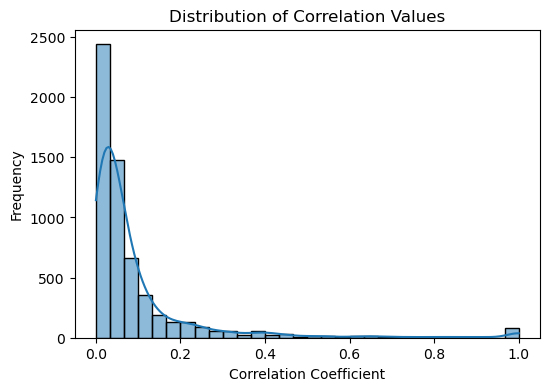

Correlation summary statistics:
count    5929.000000
mean        0.093471
std         0.157424
min         0.000091
25%         0.018445
50%         0.043022
75%         0.092294
max         1.000000
dtype: float64


In [65]:
flattened_corr = corr_matrix.values.flatten()
plt.figure(figsize=(6, 4))
sns.histplot(flattened_corr, bins=30, kde=True)
plt.title('Distribution of Correlation Values')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()

correlation_summary = pd.Series(flattened_corr).describe()
print('Correlation summary statistics:')
print(correlation_summary)

Based on the shape of the distributionand the fact that 75% of the correlation values fall below 0.092294, the correlation threshold is set to 0.9. Features with a correlation above this treshold woul be considered highly correlated.

In [66]:
# Set a correlation threshold
threshold = 0.9

# Select highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Identify features to drop
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Identify the indices of selected features
selected_features = [x for x in range(X_all2.shape[1]) if x not in to_drop]

print(f'The selected features are the ones that have importance greater than the threshold: {threshold}, and will be kept for further analysis.')
print('Selected features to keep are:')
print(selected_features)
print(f'Selected features to drop based on the treshold of {threshold}')
print(to_drop)

The selected features are the ones that have importance greater than the threshold: 0.9, and will be kept for further analysis.
Selected features to keep are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 76]
Selected features to drop based on the treshold of 0.9
[59, 62, 66, 75]


In [67]:
# find the names of the columns
features_cor_df = feature_df.iloc[:, selected_features]

feature_drop_df = feature_df.iloc[:, to_drop]
drop_names = feature_drop_df.columns

# Print the names of the droped features
print('The droped features are:')
for name in drop_names:
    print(f'   {name}')

# Convert the new Features Data Frame after coreelation selection is performed to NumPy Array
X_cor = features_cor_df.to_numpy()

The droped features are:
   Green channel mean
   Blue channel mean
   GLCM dissimilarity
   HU6 - Reflection Invarience


The features that are droped are Green channel mean, Blue channel mean, GLCM dissimilarity and HU6 - Reflection Invarience.

## 7.6 Feature Clustering

In this section, feature clustering is performed.

Feature clustering could contribute by:
identifing groups of features that exhibit similar patterns or behaviors across samples is valuable for understanding the inherent structure in the data,
revealing relationships and dependencies among different variables
and inspire feature engineering.

In [68]:
feature_names = features_cor_df.columns
features_data = features_cor_df.values

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_data)

The Elbow Method is used to find optimal number of clusters (k).

Firstly, we fit the model with different values of k and plot the within cluster sum of squares (WCSS/distortion) for each k.
As k increases, the WCSS tends to decrease because each cluster is more likely to have fewer data points, leading to smaller distances.
The elbow point is the point where the rate of decrease in WCSS slows down, and beyond that point imporvement becomes marginal.

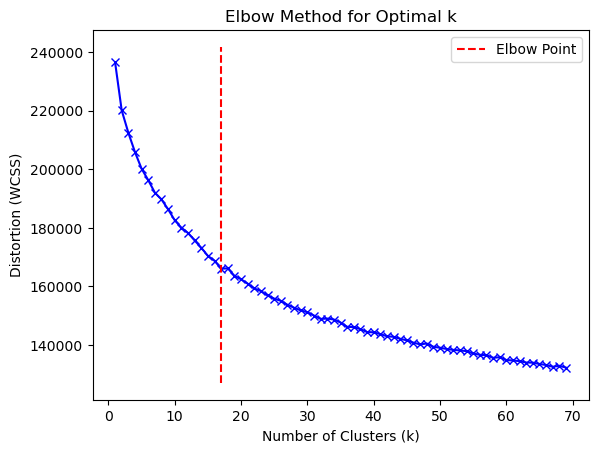

Optimal number of clusters (k) from Elbow Method: 17


In [69]:
distortions = []
K_range = range(1, 70)

# Fit a KMeans model for each value of k
for k in K_range:
    kmeanModel = KMeans(n_clusters=k, n_init=10)  # Explicitly set n_init to suppress the warning
    kmeanModel.fit(features_scaled)
    distortions.append(kmeanModel.inertia_)

# Use the KneeLocator to find the elbow point
knee_locator = KneeLocator(K_range, distortions, curve='convex', direction='decreasing')
elbow_point = knee_locator.elbow

# Plot the Elbow Curve
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow Point')
plt.legend()
plt.show()

# The variable elbow_point contains the optimal number of clusters (k)
print("Optimal number of clusters (k) from Elbow Method:", elbow_point)

The plot shows the relationship between the number of clusters (k) and the distortion (WCSS) in K-means clustering.
The X-axis shows the number of clusters and shows Y-axis represents the distortion.
The red dashed line indicates the position of the elbow point and it helsp visually assess where the rate of decrease in distortion slows down.

C:\Users\desik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


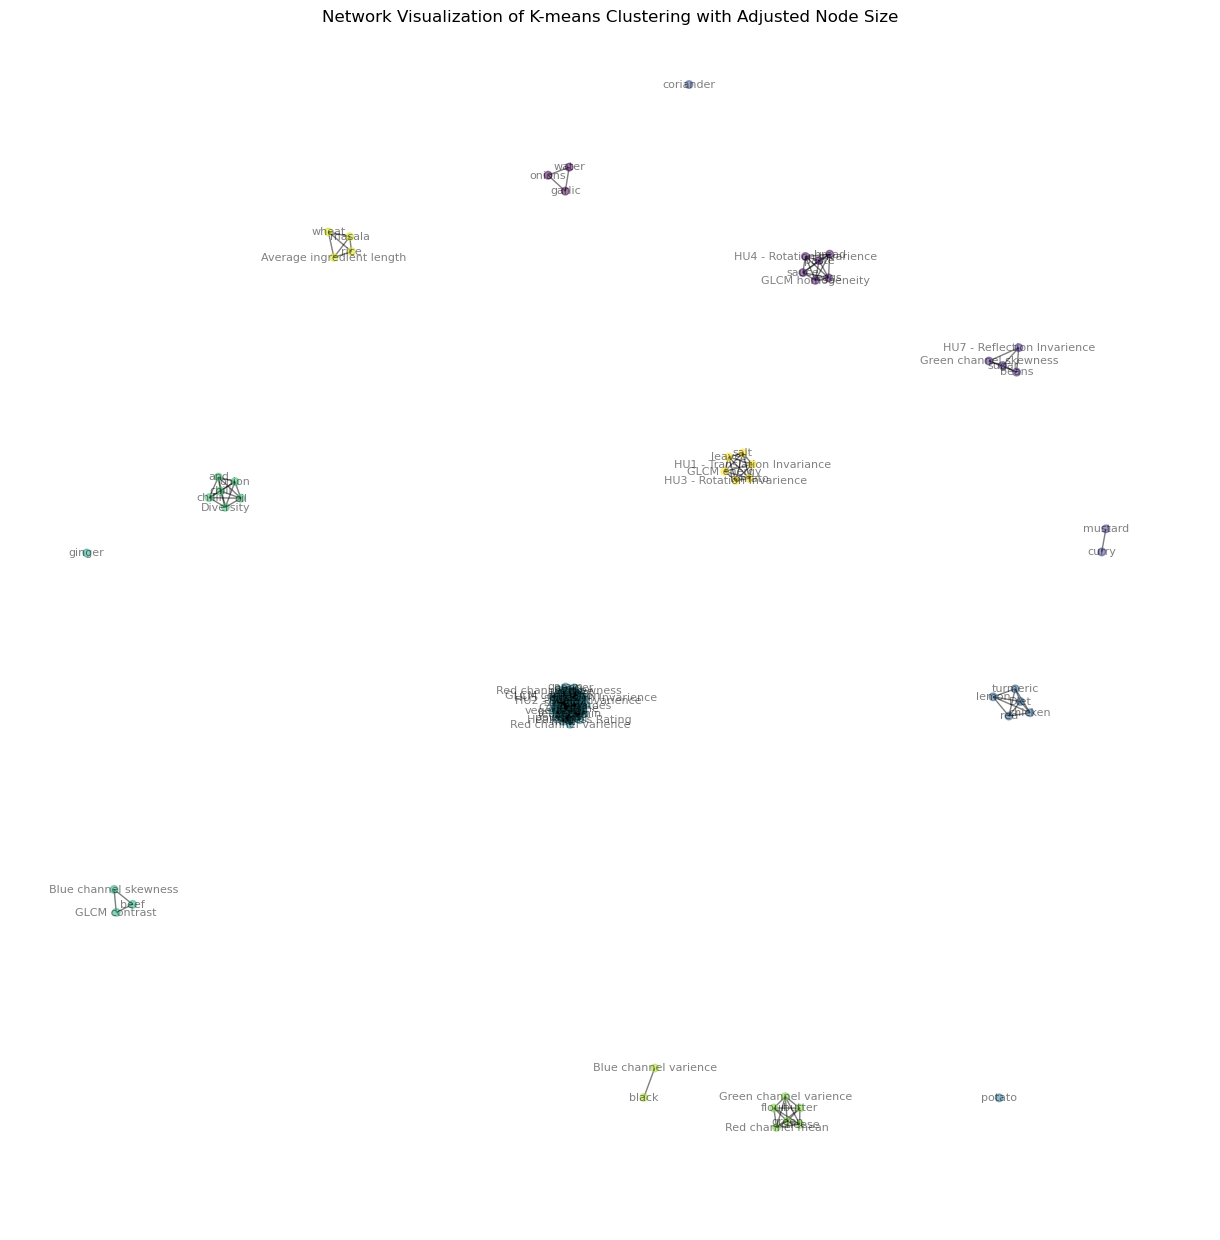

In [70]:
# Choose the number of clusters (k)
k = elbow_point

# Apply K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_assignments = kmeans.fit_predict(features_scaled)

clustered_df = pd.DataFrame(features_scaled, columns=feature_names)
clustered_df['Cluster'] = cluster_assignments

# DataFrame for the network
network_df = pd.DataFrame(index=feature_names, columns=feature_names, data=0)

# Count co-occurrences of features in the same cluster
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        if cluster_assignments[i] == cluster_assignments[j]:
            network_df.at[feature_names[i], feature_names[j]] += 1
            network_df.at[feature_names[j], feature_names[i]] += 1

# Graph for the network
G = nx.from_pandas_adjacency(network_df)

# Get the cluster assignments for the nodes in the graph
node_clusters = [cluster_assignments[feature_names.get_loc(node)] for node in G.nodes]

# Layout for the nodes with increased scale
layout = nx.spring_layout(G, scale=10000)

plt.figure(figsize=(12, 12))
nx.draw(G, pos=layout, with_labels=True, font_size=8, node_size=30, node_color=node_clusters, cmap=plt.cm.viridis, alpha =0.5)
plt.title("Network Visualization of K-means Clustering with Adjusted Node Size")
plt.show()

The network visualisation plot represents the relationships between features based on their clustering patterns obtained from K-means clustering.
Each noed represents a feature.
An edge indicates that the features it connects are clusterd together.

Features within the same cluster are grouped together and share tha same colour.

Isolated nodes, nodes that are not connected to any others, are features that are not frequently clustered with other features. Such features are curry, potato, GLCM contrast and ginger.

There are interesting cluseters possibly useful for further anlaysis and considerations.<br>
Mustard, wheat and tomato are clustered together.
Milk, powder and vegetable are clustered together.
Olive and corriander are clustered together.
Masala, average ingredient length and rice are clustered together.
Lemon, turmeric, chicken and Diet are clustered together.

I would be interesting to explore whether certain occurance of words in ingredients contribute more towards likeness rating.

## 7.7 PCA

The shape of the predictors space is displayed.

In [71]:
X_cor2 = X_cor.copy()
X_cor2.shape

(3241, 73)

Perform a Principal Component Analysis (PCA).

PCA is a dimensionality reduction technique that is used to transform high-dimensional data into a lower-dimensional representation while preserving the most important information.

In [72]:
# Standardise the data
X_standard = StandardScaler().fit_transform(X_cor2)

# Create a PCA instance
pca = PCA(random_state=42)

# Fit the PCA model to the standardized data
principal_components = pca.fit_transform(X_standard)

# Access the explained variance ratio, the proportion of variance captured by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative sum of explained variance ratios to decide the number of components to keep
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

The number of principal components retained is based on the explained varience; the number of components that capture sufficiently high percentage of the total varience. <br>
The explained variance of each principal component is given by the ratio of its eigenvalue to the sum of all eigenvalues. The cumulative explained variance represents the proportion of the total variance explained by the first k principal components.

The chosen treshold is 95% cumulative explained variance.

The plot where the cumulative explained variance against the number of principal components is visualised, provides insights into how much information is retained as the number of components is increased.
The X-axis shows the number of principal components and the Y-axis shows the cumulative proportion of total varience explained by the retained principal components, calculated by summing up the individual explained variences of each component.
The blue line indicates how the cumulative explained bvarience increases as more principal components are included.
The red dashed line represents the desired level of cumulative explained variance and indicates where the cumulative explained varience meets the specified treshold.

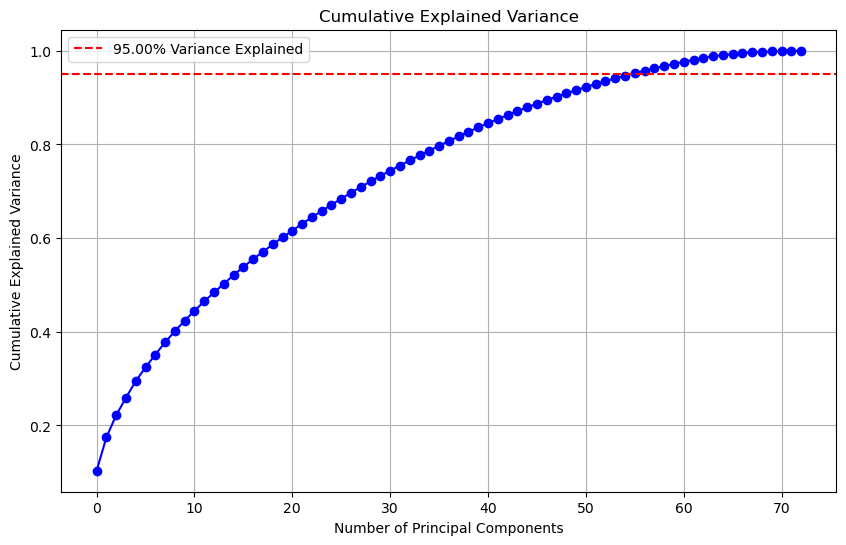

In [73]:
# Determine the number of components to keep - 95% of variance
desired_variance_explained = 0.95
num_components_to_keep = np.argmax(cumulative_explained_variance >= desired_variance_explained) + 1

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-', color='b')
plt.axhline(y=desired_variance_explained, color='r', linestyle='--', label=f'{desired_variance_explained*100:.2f}% Variance Explained')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

Principal Component 1 (PC1) is the first principal component obtained through Principal Component Analysis (PCA). The original variables are transformed into a new set of uncorrelated variables called principal components.

PC1 is the linear combination of the original variables that captures the most variance in the data. In other words, PC1 is the direction in the feature space along which the data varies the most. It accounts for the maximum amount of variability among the data points.The loadings indicate the contribution of each original feature to the construction of PC1. The larger the absolute value of a loading, the more important the corresponding feature is in determining the values of PC1. Then, the second principal component (PC2) is uncorrelated to PC1 and explains the second most variance, and so on.

In practice, interpreting PC1 involves understanding which original features have the most significant positive or negative loadings and how these loadings contribute to the overall variability captured by PC1. PC1 is often used as a summary or representative variable that condenses the information from the original features.

Each principal component is a linear combination of the original features.<br>
The loadings of each original feature on a principal component represent the contribution of that feature to the principal component. Positive or negative loadings indicate the direction and strength of the relationship with the principal component.<br>

The loadings for PC1 are displayed below.

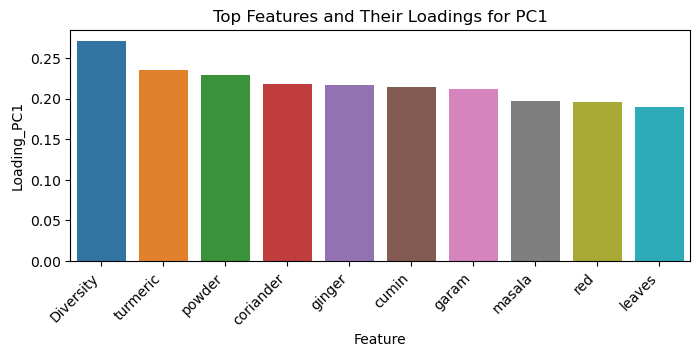

In [74]:
loadings_pc1 = pca.components_[0, :]

# Create a DataFrame for better visualization
loading_df = pd.DataFrame({'Feature': features_cor_df.columns, 'Loading_PC1': loadings_pc1})
loading_df = loading_df.reindex(loading_df['Loading_PC1'].abs().sort_values(ascending=False).index)

# Assuming 'loading_df' is the DataFrame with loadings
plt.figure(figsize=(8, 3))
sns.barplot(x='Feature', y='Loading_PC1', data=loading_df.head(10))
plt.title('Top Features and Their Loadings for PC1')
plt.xticks(rotation=45, ha='right')
plt.show()

The positive loadings for these features suggest that higher values of these original features are associated with higher values of the first principal component. The magnitude of the loading indicates the strength of the association. 

Now, the lower-dimensional representation of the data is obtained.

In [75]:
# Project the data onto the new feature space
X_pca = principal_components[:, :num_components_to_keep]
X_pca.shape

(3241, 56)

# 8 Results

Firstly all the functions used in this section are displayed in section 8.0 Functions for more uniformed view.

Then for each of the chosen models in section 5 Modelling, the methodology described in section 6 Metodology is carried.

## 8.0 Functions

In [76]:
def data_splitting(X, y_encoded, test_size=0.3, random_state=42):
    """
    Train-Validation-Test Split with split ratio 60-20-20 with stratification.

    Parameters:
    - X: Feature matrix.
    - y_encoded: Target variable (encoded).
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed for random number generation.
    
    Prints:
    - thee shapes of the feature matrices for training, validation, and test sets.
    Returns:
    - X_train, X_val, X_test: Feature matrices for training, validation, and test sets.
    - y_train, y_val, y_test: Target variables for training, validation, and test sets.
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state, stratify=y_temp)

    print('Shapes:')
    print(f'Training subset shape: {X_train.shape}')
    print(f'Validation subset shape: {X_val.shape}')
    print(f'Test subset shape: {X_test.shape}')

    return X_train, X_val, X_test, y_train, y_val, y_test

In [77]:
def evaluate_linreg_performance(model, name, X, feature_matrix_name, y):
    """
    Evaluate the performance of a linreg regression model on a given dataset.

    Parameters:
    - model: The trained classification model.
    - name: The name of the classification model
    - X: Feature matrix.
    - feature_matrix_name: Feature matrix name.
    - y: Target variable.
   
    Returns:
    - model, hyperparameters and evaluation metrics as a DataFrame
    """

    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    evs = explained_variance_score(y, y_pred)
                               
    return pd.DataFrame({
        'Model': [name],
        'Feature_Matrix': [feature_matrix_name],
        'fit_intercept': [model.fit_intercept] if hasattr(model, 'fit_intercept') else None,
        'positive': [model.positive] if hasattr(model, 'positive') else None,
        'MSE': [round(mse,4)],
        'MAE': [round(mae,4)],
        'R2': [round(r2,4)],
        'Explained Varience Score': [round(evs, 4)],
    })

In [78]:
def plot_scatter(actual_values, predicted_values, title):
    """
    Create a scatter plot comparing actual values to predicted values.

    Parameters:
    - actual_values: The actual values from the test set.
    - predicted_values: The predicted values from the model.
    - title: The title of the plot.

    Returns:
    - None (displays the plot)
    """
    plt.scatter(actual_values, predicted_values, label='Test Set', alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.legend()
    plt.show()

In [79]:
def evaluate_rf_performance(model, name, X, feature_matrix_name, y):
    """
    Evaluate the performance of a random forest regressor model on a given dataset.

    Parameters:
    - model: The trained classification model.
    - name: The name of the classification model
    - X: Feature matrix.
    - feature_matrix_name: Feature matrix name.
    - y: Target variable.
   
    Returns:
    - evaluation metrics as a DataFrame
    """

    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    evs = explained_variance_score(y, y_pred)
                               
    return pd.DataFrame({
        'Model': [name],
        'Feature_Matrix': [feature_matrix_name],
        'N estimator': [model.n_estimators] if hasattr(model, 'n_estimators') else None,
        'Max Depth': [model.max_depth] if hasattr(model, 'max_depth') else None,
        'Min Samples Split': [model.min_samples_split] if hasattr(model, 'min_samples_split') else None,
        'Min Samples Leaf': [model.min_samples_leaf] if hasattr(model, 'min_samples_leaf') else None,
        'Max Features': [model.max_features] if hasattr(model, 'max_features') else None,
        'MSE': [round(mse,4)],
        'MAE': [round(mae,4)],
        'R2': [round(r2,4)],
        'Explained Varience Score': [round(evs, 4)],
    })

In [80]:
def evaluate_gb_performance(model, name, X, feature_matrix_name, y):
    """
    Evaluate the performance of a gradient boosting regressor model on a given dataset.

    Parameters:
    - model: The trained classification model.
    - name: The name of the classification model
    - X: Feature matrix.
    - feature_matrix_name: Feature matrix name.
    - y: Target variable.
   
    Returns:
    - evaluation metrics as a DataFrame
    """

    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    evs = explained_variance_score(y, y_pred)
                               
    return pd.DataFrame({
        'Model': [name],
        'Feature_Matrix': [feature_matrix_name],
        'N estimator': [model.n_estimators] if hasattr(model, 'n_estimators') else None,
        'Learning Rate': [model.learning_rate] if hasattr(model, 'learning_rate') else None,
        'Subsample': [model.subsample] if hasattr(model, 'subsample') else None,
        'Max Depth': [model.max_depth] if hasattr(model, 'max_depth') else None,
        'Min Samples Split': [model.min_samples_split] if hasattr(model, 'min_samples_split') else None,
        'Min Samples Leaf': [model.min_samples_leaf] if hasattr(model, 'min_samples_leaf') else None,
        'Max Features': [model.max_features] if hasattr(model, 'max_features') else None,
        'MSE': [round(mse,4)],
        'MAE': [round(mae,4)],
        'R2': [round(r2,4)],
        'Explained Varience Score': [round(evs, 4)],
    })

In [81]:
def feature_scaling(X_train, X_val, X_test):
    """
    Scale features using StandardScaler.

    Parameters:
    - X_train: Feature matrix for training set.
    - X_val: Feature matrix for validation set.
    - X_test: Feature matrix for test set.

    Returns:
    - X_train_scaled, X_val_scaled, X_test_scaled: Scaled feature matrices.
    """
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled

In [82]:
def evaluate_mlp_performance(model, name, X, feature_matrix_name, y):
    """
    Evaluate the performance of a multi-layer perceptron regressor model on a given dataset.

    Parameters:
    - model: The trained classification model.
    - name: The name of the classification model
    - X: Feature matrix.
    - feature_matrix_name: Feature matrix name.
    - y: Target variable.
   
    Returns:
    - evaluation metrics as a DataFrame
    """

    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    evs = explained_variance_score(y, y_pred)
                               
    return pd.DataFrame({
        'Model': [name],
        'Feature_Matrix': [feature_matrix_name],
        'hidden_layer_sizes': [model.hidden_layer_sizes] if hasattr(model, 'hidden_layer_sizes') else None,
        'Learning Rate': [model.learning_rate] if hasattr(model, 'learning_rate') else None,
        'Activation': [model.activation] if hasattr(model, 'activation') else None,
        'Alpha': [model.alpha] if hasattr(model, 'alpha') else None,
        'Max_iter': [model.max_iter] if hasattr(model, 'max_iter') else None,
        'MSE': [round(mse,4)],
        'MAE': [round(mae,4)],
        'R2': [round(r2,4)],
        'Explained Varience Score': [round(evs, 4)],
    })

## 8.1 Linear Regression Model

### 8.1.1 Step 1: Data Splitting

In [83]:
linreg_X_train, linreg_X_val, linreg_X_test, linreg_y_train, linreg_y_val, linreg_y_test = data_splitting(X_cor, y_encoded, test_size=0.3, random_state=42)

Shapes:
Training subset shape: (2268, 73)
Validation subset shape: (486, 73)
Test subset shape: (487, 73)


### 8.1.2 Step 2: Model Training

In [84]:
# Train the Linear Regression model with default parameters
linreg = LinearRegression()
linreg.fit(linreg_X_train, linreg_y_train)

LinearRegression()

In [85]:
# results on train subset with default linreg model
linreg_results_df =pd.DataFrame()
result = evaluate_linreg_performance(linreg, 'Default Linear Regression', linreg_X_train, 'Train Subset', linreg_y_train)
linreg_results_df = pd.concat([linreg_results_df, result], ignore_index=True)
linreg_results_df 

,Model,Feature_Matrix,fit_intercept,positive,MSE,MAE,R2,Explained Varience Score
0,Default Linear Regression,Train Subset,True,False,0.8293,0.7094,0.0568,0.0568


### 8.1.3 Step 3: Validation and Hyperparameter Tuning

The parameters that are tuned are:

- fit_intercept: A choice whether to calculate the intercept for the model.

- positive: A choice whether to force the coefficients to be positive.

In [86]:
# results on validation subset with default linreg model
result = evaluate_linreg_performance(linreg, 'Default Linear Regression', linreg_X_val, 'Validation Subset', linreg_y_val)
linreg_results_df = pd.concat([linreg_results_df, result], ignore_index=True)

In [87]:
# grid search
linreg_param_grid = {'fit_intercept': [True, False],
                 'positive': [True, False]}
                     
linreg_grid_search = GridSearchCV(linreg, linreg_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
linreg_grid_search.fit(linreg_X_val, linreg_y_val)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

In [88]:
# get the tuned linreg model
tuned_linreg = linreg_grid_search.best_estimator_
print('The result for Best Linear Regression Model with 5-fold cross-validation with MSE as evaluation metric are is:')
print(tuned_linreg)

The result for Best Linear Regression Model with 5-fold cross-validation with MSE as evaluation metric are is:
LinearRegression(fit_intercept=False)


In [89]:
# Retrain the tuned linreg model with the best hyperparameters on the Train Subset
tuned_linreg.fit(linreg_X_train, linreg_y_train)

LinearRegression(fit_intercept=False)

In [90]:
# results on train subset with tuned linreg model
result = evaluate_linreg_performance(tuned_linreg, 'Tuned Linear Regression', linreg_X_train, 'Train Subset', linreg_y_train)
linreg_results_df = pd.concat([linreg_results_df, result], ignore_index=True)

In [91]:
# results on validation subset with tuned linreg model
result = evaluate_linreg_performance(tuned_linreg, 'Tuned Linear Regression', linreg_X_val, 'Validation Subset', linreg_y_val)
linreg_results_df = pd.concat([linreg_results_df, result], ignore_index=True)

In [92]:
linreg_results_df

,Model,Feature_Matrix,fit_intercept,positive,MSE,MAE,R2,Explained Varience Score
0,Default Linear Regression,Train Subset,True,False,0.8293,0.7094,0.0568,0.0568
1,Default Linear Regression,Validation Subset,True,False,0.8963,0.7474,-0.0163,-0.0163
2,Tuned Linear Regression,Train Subset,False,False,0.8314,0.7103,0.0544,0.0544
3,Tuned Linear Regression,Validation Subset,False,False,0.8940,0.7460,-0.0137,-0.0137


Default Linear Regression Model (fit_intercept=True, positive=False)<br>
Tuned Linear Regression Model (fit_intercept=False, positive=False)

The performance metrics of the Default and Tuned models are quite similar with minimal differences, suggesting that changing the fit_intercept parameter did not significantly impact the model's performance on these subsets. Both the Default and Tuned models show better performance on the Train Subset compared to the Validation Subset, suggesting that both Default an Tuned models do not generalise well to new unseen data.

The Tuned model has slightly lower MSE, MAE, a less negative R2 and a less negative Explained Variance Score compared to the Default model

Thus the model that would be tested is Tuned Linear Regression Model (fit_intercept=False, positive=False).

### 8.1.4 Step 4: Model Evaluation

In [93]:
linreg_y_test_pred = tuned_linreg.predict(linreg_X_test)

The scatter plot visualises predicted values against the actual values and shows that the model does not generalise well to new unseen data.

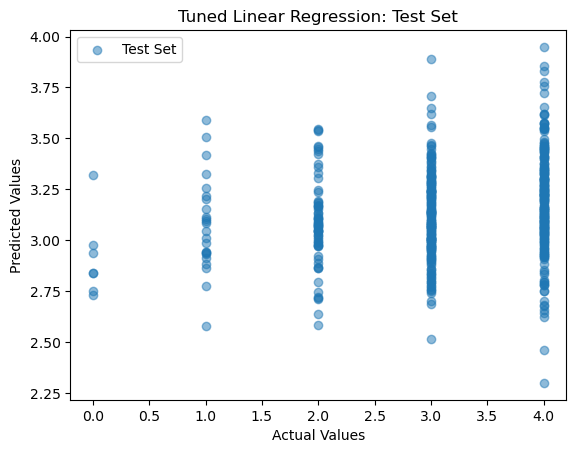

In [94]:
# Scatter plot for test set
plot_scatter(linreg_y_test, linreg_y_test_pred, 'Tuned Linear Regression: Test Set')

In [95]:
# results on test subset with tuned linreg model
result = evaluate_linreg_performance(tuned_linreg, 'Tuned Linear Regression', linreg_X_test, 'Test Subset', linreg_y_test)
linreg_results_df = pd.concat([linreg_results_df, result], ignore_index=True)
linreg_results_df

,Model,Feature_Matrix,fit_intercept,positive,MSE,MAE,R2,Explained Varience Score
0,Default Linear Regression,Train Subset,True,False,0.8293,0.7094,0.0568,0.0568
1,Default Linear Regression,Validation Subset,True,False,0.8963,0.7474,-0.0163,-0.0163
2,Tuned Linear Regression,Train Subset,False,False,0.8314,0.7103,0.0544,0.0544
3,Tuned Linear Regression,Validation Subset,False,False,0.8940,0.7460,-0.0137,-0.0137
4,Tuned Linear Regression,Test Subset,False,False,0.8425,0.7152,0.0369,0.0371


The Tuned model's performance on the Train Subset is similar to that on the Test Subset, suggesting reasonable generalisation to new, unseen data. The higher MSE and MAE on the Validation Subset compared to the Train and Test subsets indicate that the model  struggles with some aspects of the validation data, potentially due to different characteristics.
The R2 values for both the Train and Test Subsets are positive, suggesting that the model explains some of the variance in the target variable. The values are relatively low, indicating that the model does not capture all the underlying patterns in the data.
<br>The model, as configered and trained, does not predict the likeness rating well.

## 8.2 Random Forest Regressor Model

### 8.2.1 Step 1: Data Splitting

In [96]:
rf_X_train, rf_X_val, rf_X_test, rf_y_train, rf_y_val, rf_y_test = data_splitting(X_cor, y_encoded, test_size=0.3, random_state=42)

Shapes:
Training subset shape: (2268, 73)
Validation subset shape: (486, 73)
Test subset shape: (487, 73)


### 8.2.2 Step 2: Model Training

In [97]:
# Train the Random Forest Regressor model with default parameters; random state = 42 to ensure reproducibility
rf = RandomForestRegressor(random_state=42)
rf.fit(rf_X_train, rf_y_train)

RandomForestRegressor(random_state=42)

In [98]:
# results on train subset with default rf model
rf_results_df =pd.DataFrame()
result = evaluate_rf_performance(rf, 'Default Random Forest Regressor', rf_X_train, 'Train Subset', rf_y_train)
rf_results_df = pd.concat([rf_results_df, result], ignore_index=True)
rf_results_df 

,Model,Feature_Matrix,N estimator,Max Depth,Min Samples Split,Min Samples Leaf,Max Features,MSE,MAE,R2,Explained Varience Score
0,Default Random Forest Regressor,Train Subset,100,None,2,1,1.0,0.117,0.2688,0.8669,0.8672


### 8.2.3 Step 3: Validation and Hyperparameter Tuning

The parameters that are tuned are:

- n_estimators - the number of trees in the forest. Increasing the number of trees usually improves the model's performance.

- max_depth - the maximum depth of the trees and helps prevent overfitting. Higher values for depth tend to model the training data more precisely but might not generalise well to unseen data.

- min_samples_split - the minimum number of samples required to split an internal node. Higher values tend to reduce overfitting.

- min_samples_leaf - the minimum number of samples required to be at a leaf node. Higher values tend to prevent overfitting.

 - max_features - the number of features to consider when looking for the best split

In [99]:
# results on validation subset with default rf model
result = evaluate_rf_performance(rf, 'Default Random Forest Regressor', rf_X_val, 'Validation Subset', rf_y_val)
rf_results_df = pd.concat([rf_results_df, result], ignore_index=True)

In [127]:
# randomised search
rf_param_dist = {'n_estimators': [10, 20, 50, 100, 200],
                 'max_depth': randint(2, 20),
                 'min_samples_split': randint(2, 20),
                 'min_samples_leaf': randint(1, 20),
                 'max_features': ['sqrt', 'log2', None],
                 'random_state': [42]}

rf_random_search = RandomizedSearchCV(rf, rf_param_dist, n_iter=1000, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=1)
rf_random_search.fit(rf_X_val, rf_y_val)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits



KeyboardInterrupt



In [101]:
# get the tuned rf model
tuned_rf = rf_random_search.best_estimator_
print('The result for Best Random Forest Regressor Model with 5-fold cross-validation with MSE as evaluation metric is:')
print(tuned_rf)

The result for Best Random Forest Regressor Model with 5-fold cross-validation with MSE as evaluation metric is:
RandomForestRegressor(max_depth=14, max_features='log2', min_samples_split=3,
                      n_estimators=200, random_state=42)


In [102]:
# Retrain the tuned rf model with the best hyperparameters on the Train Subset
tuned_rf.fit(rf_X_train, rf_y_train)

RandomForestRegressor(max_depth=14, max_features='log2', min_samples_split=3,
                      n_estimators=200, random_state=42)

In [103]:
# results on train subset with tuned rf model
result = evaluate_rf_performance(tuned_rf, 'Tuned Random Forest Regressor', rf_X_train, 'Train Subset', rf_y_train)
rf_results_df = pd.concat([rf_results_df, result], ignore_index=True)

In [104]:
# results on validation subset with tuned rf model
result = evaluate_rf_performance(tuned_rf, 'Tuned Random Forest Regressor', rf_X_val, 'Validation Subset', rf_y_val)
rf_results_df = pd.concat([rf_results_df, result], ignore_index=True)

In [105]:
rf_results_df

,Model,Feature_Matrix,N estimator,Max Depth,Min Samples Split,Min Samples Leaf,Max Features,MSE,MAE,R2,Explained Varience Score
0,Default Random Forest Regressor,Train Subset,100,None,2,1,1.0,0.1170,0.2688,0.8669,0.8672
1,Default Random Forest Regressor,Validation Subset,100,None,2,1,1.0,0.8697,0.7458,0.0139,0.0166
2,Tuned Random Forest Regressor,Train Subset,200,14,3,1,log2,0.3490,0.4666,0.6030,0.6031
3,Tuned Random Forest Regressor,Validation Subset,200,14,3,1,log2,0.8507,0.7219,0.0354,0.0356


Default RandomForest Regressor(max_depth=None, max_features=1.0, min_samples_split=2, min_samples_leaf=1, n_estimators=100, random_state=42)<br>
Tuned Random Forest Regressor(max_depth=14, max_features='log2', min_samples_split=3, min_samples_leaf=1, n_estimators=200, random_state=42)

The tuning has resulted in changes in performance metrics on both the Train and Validation subsets.

The Tuned model performs significantly better on the Train Subset than on the Validation Subset, indicating potential overfitting.
The Default model, while having a good performance on the Train Subset, struggles on the Validation Subset.

The Tuned model has a higher MSE and MAE on the Validation Subset compared to the Train Subset, suggesting a lack of generalisation and the R2 and Explained Variance Score values for the Tuned model on the Validation Subset are lower than those on the Train Subset, indicating overfitting.

As the tuned model is likely overfitting the training data, the model that would be tested is: <br>
Default RandomForest Regressor(max_depth=None, max_features=1.0, min_samples_split=2, min_samples_leaf=1, n_estimators=100, random_state=42)

### 8.2.4 Step 4: Model Evaluation

In [106]:
rf_y_test_pred = rf.predict(rf_X_test)

The scatter plot visualises predicted values against the actual values and shows that the model is does not evefectively generalise to new unseen data.

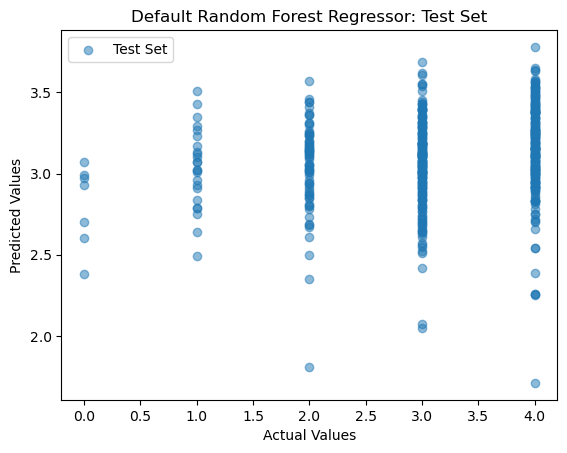

In [107]:
# Scatter plot for test set
plot_scatter(rf_y_test, rf_y_test_pred, 'Default Random Forest Regressor: Test Set')

In [108]:
# results on test subset with tuned rf model
result = evaluate_rf_performance(rf, 'Default Random Forest Regressor', rf_X_test, 'Test Subset', rf_y_test)
rf_results_df = pd.concat([rf_results_df, result], ignore_index=True)
rf_results_df

,Model,Feature_Matrix,N estimator,Max Depth,Min Samples Split,Min Samples Leaf,Max Features,MSE,MAE,R2,Explained Varience Score
0,Default Random Forest Regressor,Train Subset,100,None,2,1,1.0,0.1170,0.2688,0.8669,0.8672
1,Default Random Forest Regressor,Validation Subset,100,None,2,1,1.0,0.8697,0.7458,0.0139,0.0166
2,Tuned Random Forest Regressor,Train Subset,200,14,3,1,log2,0.3490,0.4666,0.6030,0.6031
3,Tuned Random Forest Regressor,Validation Subset,200,14,3,1,log2,0.8507,0.7219,0.0354,0.0356
4,Default Random Forest Regressor,Test Subset,100,None,2,1,1.0,0.8538,0.7307,0.0241,0.0278


The performance metrics: MSE, MAE, R2, Explained Variance Score, are relatively consistent across the Train, Validation, and Test Subsets, which is a positive sign of generalisation. The model shows good performance on the Train Subset, as indicated by low MSE, MAE, and high R2 and Explained Variance Score. The model generalises reasonably well to the Validation and Test Subsets, with similar performance metrics.

Overall, the Default Random Forest Regressor seems to be performing reasonably well across subsets, but further refinement hyperparameters or better feature selection may lead to incremental improvements.

## 8.3 Gradient Boosting Regressor Model

### 8.3.1 Step 1: Data Splitting

In [109]:
gb_X_train, gb_X_val, gb_X_test, gb_y_train, gb_y_val, gb_y_test = data_splitting(X_cor, y_encoded, test_size=0.3, random_state=42)

Shapes:
Training subset shape: (2268, 73)
Validation subset shape: (486, 73)
Test subset shape: (487, 73)


### 8.3.2 Step 2: Model Training

In [110]:
# Train the Gradient Boosting Regressor model with default parameters; random state = 42 to ensure reproducibility
gb= GradientBoostingRegressor(random_state=42)
gb.fit(gb_X_train, gb_y_train)

GradientBoostingRegressor(random_state=42)

In [111]:
# results on train subset with default gb model
gb_results_df =pd.DataFrame()
result = evaluate_gb_performance(gb, 'Default Gradient Boosting Regressor', gb_X_train, 'Train Subset', gb_y_train)
gb_results_df = pd.concat([gb_results_df, result], ignore_index=True)
gb_results_df 

,Model,Feature_Matrix,N estimator,Learning Rate,Subsample,Max Depth,Min Samples Split,Min Samples Leaf,Max Features,MSE,MAE,R2,Explained Varience Score
0,Default Gradient Boosting Regressor,Train Subset,100,0.1,1.0,3,2,1,None,0.6116,0.6163,0.3044,0.3044


### 8.3.3 Step 3: Validation and Hyperparameter Tuning

The parameters that are tuned are:

- n_estimators - the number of trees in the forest. Increasing the number of trees usually improves the model's performance.

- learning_rate - shrinks the contribution of each tree by learning_rate.

- max_depth - the maximum depth of the trees and helps prevent overfitting. Higher values for depth tend to model the training data more precisely but might not generalise well to unseen data.

- min_samples_split - the minimum number of samples required to split an internal node. Higher values tend to reduce overfitting.

- min_samples_leaf - the minimum number of samples required to be at a leaf node. Higher values tend to prevent overfitting.

- subsample - the fraction of samples to be used for fitting the individual base learners.

- max_features - the number of features to consider when looking for the best split.

In [112]:
# results on validation subset with default gb model
result = evaluate_gb_performance(gb, 'Default Gradient Boosting Regressor', gb_X_val, 'Validation Subset', gb_y_val)
gb_results_df = pd.concat([gb_results_df, result], ignore_index=True)

In [113]:
# randomised search
gb_param_dist = {'n_estimators': [10, 50, 100, 150, 200],
                 'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                 'max_depth': randint(3, 20),
                 'min_samples_split': randint(2, 20),
                 'min_samples_leaf': randint(1, 10),
                 'subsample': [0.7, 0.8, 0.9, 1],
                 'max_features': ['sqrt', 'log2', None],
                 'random_state': [42]}

gb_random_search = RandomizedSearchCV(gb, gb_param_dist, n_iter=1000, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=1)
gb_random_search.fit(gb_X_val, gb_y_val)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=1000,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.5],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024203E75B50>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024203E53450>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002424BF42350>,
                                        'n_estimators': [10, 50, 100, 150, 200],
                                        'random_state': [42],
                                        'subsample': [0.7, 0.8, 0.9, 1]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [114]:
# get the tuned gb model
tuned_gb = gb_random_search.best_estimator_
print('The result for Best Gradient Boosting Regressor Model with 5-fold cross-validation with MSE as evaluation metric is:')
print(tuned_gb)

The result for Best Gradient Boosting Regressor Model with 5-fold cross-validation with MSE as evaluation metric is:
GradientBoostingRegressor(learning_rate=0.05, max_depth=14, max_features='log2',
                          min_samples_leaf=3, min_samples_split=4,
                          n_estimators=150, random_state=42, subsample=1)


In [115]:
# Retrain the tuned gb model with the best hyperparameters on the Train Subset
tuned_gb.fit(gb_X_train, gb_y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=14, max_features='log2',
                          min_samples_leaf=3, min_samples_split=4,
                          n_estimators=150, random_state=42, subsample=1)

In [116]:
# results on train subset with tuned gb model
result = evaluate_gb_performance(tuned_gb, 'Tuned Gradient Boosting Regressor', gb_X_train, 'Train Subset', gb_y_train)
gb_results_df = pd.concat([gb_results_df, result], ignore_index=True)

In [117]:
# results on validation subset with tuned gb model
result = evaluate_gb_performance(tuned_gb, 'Tuned Gradient Boosting Regressor', gb_X_val, 'Validation Subset', gb_y_val)
gb_results_df = pd.concat([gb_results_df, result], ignore_index=True)

In [118]:
gb_results_df

,Model,Feature_Matrix,N estimator,Learning Rate,Subsample,Max Depth,Min Samples Split,Min Samples Leaf,Max Features,MSE,MAE,R2,Explained Varience Score
0,Default Gradient Boosting Regressor,Train Subset,100,0.10,1.0,3,2,1,None,0.6116,0.6163,0.3044,0.3044
1,Default Gradient Boosting Regressor,Validation Subset,100,0.10,1.0,3,2,1,None,0.8607,0.7266,0.0241,0.0243
2,Tuned Gradient Boosting Regressor,Train Subset,150,0.05,1.0,14,4,3,log2,0.0094,0.0668,0.9893,0.9893
3,Tuned Gradient Boosting Regressor,Validation Subset,150,0.05,1.0,14,4,3,log2,0.8652,0.7400,0.0190,0.0190


Default Gradient Boosting Regressor (learning_rate=0.1, max_depth=3, max_features=None, 
                          min_samples_leaf=1, min_samples_split=2,
                          n_estimators=100, random_state=42, subsample=1)<br>
Tuned Gradient Boosting Regressor (learning_rate=0.05, max_depth=14, max_features='log2',
                          min_samples_leaf=3, min_samples_split=4,
                          n_estimators=150, random_state=42, subsample=1)

The tuning has resulted in substantial improvements, especially on the Train Subset.
The Tuned model performs exceptionally well on the Train Subset, achieving very low MSE and MAE, and a high R2 and Explained Variance Score, suggesting overfitting.
On the Validation Subset, the Tuned model performs similarly to the Default model, but there's still room for improvement.

As prioritisation is a balanced performance that generalises well to new, unseen data, the Default model is a better choice.
<br>Thus the model that would be tested is Default Gradient Boosting Regressor (learning_rate=0.1, max_depth=3, max_features=None, 
                          min_samples_leaf=1, min_samples_split=2,
                          n_estimators=100, random_state=42, subsample=1)

### 8.3.4 Step 4: Model Evaluation

In [134]:
gb_y_test_pred = gb.predict(gb_X_test)

The scatter plot visualises predicted values against the actual values and shows that the model does not predict the likeness rating effectively.

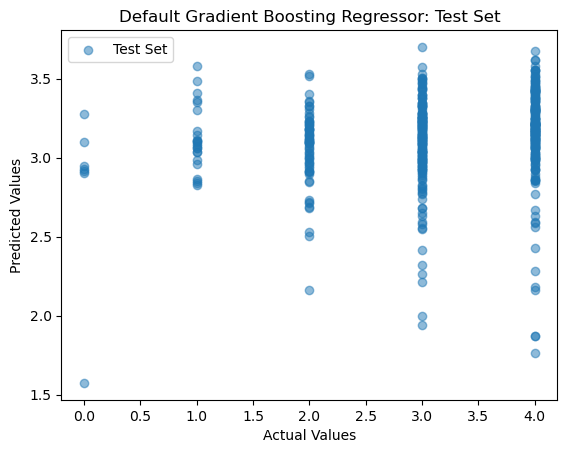

In [135]:
# Scatter plot for test set
plot_scatter(gb_y_test, gb_y_test_pred, 'Default Gradient Boosting Regressor: Test Set')

In [121]:
# results on test subset with default gb model
result = evaluate_gb_performance(gb, 'Default Gradient Boosting Regressor', gb_X_test, 'Test Subset', gb_y_test)
gb_results_df = pd.concat([gb_results_df, result], ignore_index=True)
gb_results_df

,Model,Feature_Matrix,N estimator,Learning Rate,Subsample,Max Depth,Min Samples Split,Min Samples Leaf,Max Features,MSE,MAE,R2,Explained Varience Score
0,Default Gradient Boosting Regressor,Train Subset,100,0.10,1.0,3,2,1,None,0.6116,0.6163,0.3044,0.3044
1,Default Gradient Boosting Regressor,Validation Subset,100,0.10,1.0,3,2,1,None,0.8607,0.7266,0.0241,0.0243
2,Tuned Gradient Boosting Regressor,Train Subset,150,0.05,1.0,14,4,3,log2,0.0094,0.0668,0.9893,0.9893
3,Tuned Gradient Boosting Regressor,Validation Subset,150,0.05,1.0,14,4,3,log2,0.8652,0.7400,0.0190,0.0190
4,Default Gradient Boosting Regressor,Test Subset,100,0.10,1.0,3,2,1,None,0.8708,0.7341,0.0046,0.0058


The performance metrics: MSE, MAE, R2, Explained Variance Score, show a consistent trend across the Train, Validation, and Test Subsets for Default Gradient Boosting Regressor Model.
The model, generalises well to the Test Subset with similar performance metrics on the Validation Subset. 
The better performance on the Trained Subset suggests overfitting and he R2 and Explained Variance Score on the Test Subset are relatively low, suggesting that there is room for improvement in capturing the variance in the target variable: likeness rating.

Overall, the Default model is performing reasonably well, but there is potential for improvement, especially in terms of capturing variance in the target variable on the Test Subset.

## 8.4 Multi-layer Perceptron Regressor

### 8.4.1 Step 1: Data Splitting

In [122]:
mlp_X_train, mlp_X_val, mlp_X_test, mlp_y_train, mlp_y_val, mlp_y_test = data_splitting(X_cor, y_encoded, test_size=0.3, random_state=42)

Shapes:
Training subset shape: (2268, 73)
Validation subset shape: (486, 73)
Test subset shape: (487, 73)


### 8.4.2 Step 2: Feature Scaling

In [123]:
mlp_X_train_scaled, mlp_X_val_scaled, mlp_X_test_scaled = feature_scaling(mlp_X_train, mlp_X_val, mlp_X_test)

### 8.4.3 Step 3: Model Training

In [124]:
# Train the Multi-layer Perceptron Regressor model with default parameters; random state = 42 to ensure reproducibility
# max_inter = 500 below does not converge
mlp = MLPRegressor(max_iter=500, random_state=42)
mlp.fit(mlp_X_train_scaled, mlp_y_train)

MLPRegressor(max_iter=500, random_state=42)

In [125]:
# results on train subset with default mlp model
mlp_results_df =pd.DataFrame()
result = evaluate_mlp_performance(mlp, 'Default Multi-layer Perception Regressor', mlp_X_train_scaled, 'Train Subset', mlp_y_train)
mlp_results_df = pd.concat([mlp_results_df, result], ignore_index=True)
mlp_results_df 

,Model,Feature_Matrix,hidden_layer_sizes,Learning Rate,Activation,Alpha,Max_iter,MSE,MAE,R2,Explained Varience Score
0,Default Multi-layer Perception Regressor,Train Subset,"(100,)",constant,relu,0.0001,500,0.0256,0.1036,0.9709,0.9709


### 8.4.4 Step 4: Validation and Hyperparameter Tuning

The parameters that are tuned are:

- hidden_layer_sizes - determines the architexture of the neural network
- activation - specifies the activation function for the hidden layers;'identity' (no activation function), 'logistic' (sigmoid activation), 'tanh' (hyperbolic tangent activation), and 'relu' (rectified linear unit activation)
- alpha - regularisation parameter that penalises large weights to prevent overfitting
- learning_rate -  specifies how the learning rate is adapted during training; 'constant' (keeps the learning rate constant), 'invscaling' (decreases the learning rate gradually), and 'adaptive' (keeps the learning rate constant as long as training loss keeps decreasing)

In [126]:
# results on validation subset with default mlp model
result = evaluate_mlp_performance(mlp, 'Default Multi-layer Perception Regressor', mlp_X_val_scaled, 'Validation Subset', mlp_y_val)
mlp_results_df = pd.concat([mlp_results_df, result], ignore_index=True)

In [128]:
# randomised search
mlp_param_dist = {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (50, 50, 50)],
                  'activation': ['identity', 'logistic', 'tanh', 'relu'],
                  'alpha': np.logspace(-5, 3, num=9),
                  'learning_rate': ['constant', 'invscaling', 'adaptive'],
                  'max_iter': [5000]}

mlp_random_search = RandomizedSearchCV(mlp, mlp_param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=1)
mlp_random_search.fit(mlp_X_val_scaled, mlp_y_val)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=MLPRegressor(max_iter=500, random_state=42),
                   n_iter=50,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03]),
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (50, 50),
                                                               (100, 50),
                                                               (50, 50, 50)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [5000]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [129]:
# get the tuned mlp model
tuned_mlp = mlp_random_search.best_estimator_
print('The result for Best Multi-layer Perception Regressor Model with 5-fold cross-validation with MSE as evaluation metric is:')
print(tuned_mlp)

The result for Best Multi-layer Perception Regressor Model with 5-fold cross-validation with MSE as evaluation metric is:
MLPRegressor(activation='logistic', alpha=10.0, learning_rate='invscaling',
             max_iter=5000, random_state=42)


In [130]:
# Retrain the tuned mlp model with the best hyperparameters on the Train Subset
tuned_mlp.fit(mlp_X_train_scaled, mlp_y_train)

MLPRegressor(activation='logistic', alpha=10.0, learning_rate='invscaling',
             max_iter=5000, random_state=42)

In [131]:
# results on train subset with tuned mlp model
result = evaluate_mlp_performance(tuned_mlp, 'Tuned Multi-layer Perception Regressor', mlp_X_train_scaled, 'Train Subset', mlp_y_train)
mlp_results_df = pd.concat([mlp_results_df, result], ignore_index=True)

In [132]:
# results on validation subset with tuned mlp model
result = evaluate_mlp_performance(tuned_mlp, 'Tuned Multi-layer Perception Regressor', mlp_X_val_scaled, 'Validation Subset', mlp_y_val)
mlp_results_df = pd.concat([mlp_results_df, result], ignore_index=True)

In [133]:
mlp_results_df

,Model,Feature_Matrix,hidden_layer_sizes,Learning Rate,Activation,Alpha,Max_iter,MSE,MAE,R2,Explained Varience Score
0,Default Multi-layer Perception Regressor,Train Subset,"(100,)",constant,relu,0.0001,500,0.0256,0.1036,0.9709,0.9709
1,Default Multi-layer Perception Regressor,Validation Subset,"(100,)",constant,relu,0.0001,500,3.7131,1.1616,-3.2101,-3.2035
2,Tuned Multi-layer Perception Regressor,Train Subset,"(100,)",invscaling,logistic,10.0000,5000,0.8487,0.7145,0.0347,0.0347
3,Tuned Multi-layer Perception Regressor,Validation Subset,"(100,)",invscaling,logistic,10.0000,5000,0.8743,0.7314,0.0086,0.0086


Default MLPRegressor (hidden_layer_sizes = (100,), activation='relu', alpha=0.0001, learning_rate='invscaling',
             max_iter=500, random_state=42)

Tuned MLPRegressor (hidden_layer_sizes = (100,) activation='logistic', alpha=10.0, learning_rate='invscaling',
             max_iter=5000, random_state=42)
             
The Default model performs exceptionally well on the training subset with low MSE, MAE, and high R2 and Explained Variance Score.
However, on the validation subset, the model seems to overfit, as indicated by significantly higher MSE, MAE, and negative R2 and Explained Variance Score. The Tuned model with changes in learning rate, activation, and alpha (L2 regularisation) shows improvement in terms of generalisation to the validation subset. While the performance metrics are not as strong as on the training subset, the overfitting issue seems to be mitigated.

<br>Thus the model that would be tested is Tuned MLPRegressor(hidden_layer_sizes = (100,) activation='logistic', alpha=10.0, learning_rate='invscaling',
             max_iter=5000, random_state=42)

### 8.4.5 Step 5: Model Evaluation

In [136]:
mlp_y_test_pred = tuned_mlp.predict(mlp_X_test_scaled)

The scatter plot visualises predicted values against the actual values

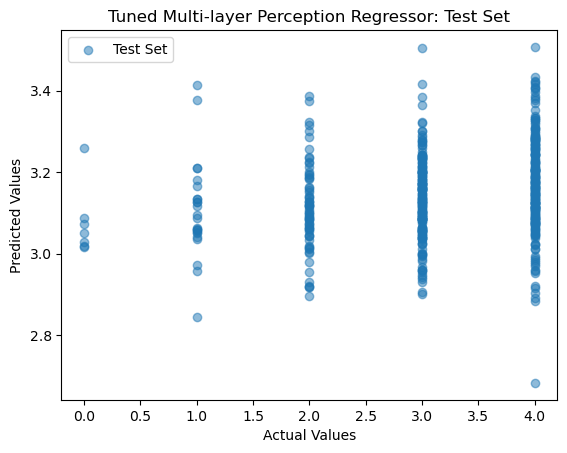

In [137]:
# Scatter plot for test set
plot_scatter(mlp_y_test, mlp_y_test_pred, 'Tuned Multi-layer Perception Regressor: Test Set')

In [138]:
# results on test subset with tuned mlp model
result = evaluate_mlp_performance(tuned_mlp, 'Tuned Multi-layer Perception Regressor', mlp_X_test_scaled, 'Test Subset', mlp_y_test)
mlp_results_df = pd.concat([mlp_results_df, result], ignore_index=True)
mlp_results_df

,Model,Feature_Matrix,hidden_layer_sizes,Learning Rate,Activation,Alpha,Max_iter,MSE,MAE,R2,Explained Varience Score
0,Default Multi-layer Perception Regressor,Train Subset,"(100,)",constant,relu,0.0001,500,0.0256,0.1036,0.9709,0.9709
1,Default Multi-layer Perception Regressor,Validation Subset,"(100,)",constant,relu,0.0001,500,3.7131,1.1616,-3.2101,-3.2035
2,Tuned Multi-layer Perception Regressor,Train Subset,"(100,)",invscaling,logistic,10.0000,5000,0.8487,0.7145,0.0347,0.0347
3,Tuned Multi-layer Perception Regressor,Validation Subset,"(100,)",invscaling,logistic,10.0000,5000,0.8743,0.7314,0.0086,0.0086
4,Tuned Multi-layer Perception Regressor,Test Subset,"(100,)",invscaling,logistic,10.0000,5000,0.8446,0.7142,0.0345,0.0346


The performance metrics for the Tuned model: MSE, MAE, R2 and Explained Variance Score, show a consistent trend across the Train, Validation, and Test Subsets. The model generalizes reasonably well to the Test Subset, with similar performance metrics to the Validation Subset.

A more in-depth analysis is needed, such as residual analysis, to identify patterns or areas for improvement in predictions.
An analysis of the feature importance is needed to understand the contributions of each feature to the predictions and possibly improve feature selection and engineering.

Overall, while the model performs reasonably well, there is room for improvement in capturing more variance in the likeness rating.

### 8.4.6 Experiment with PCA transformed data

Here the same methodology would be used but instead of feeding the `X` feature matrix, the `X_pca` would be fed into the MLPRegressor.

The Principal Component Analysis (PCA) is used to reduce the dimensionality of the feature matrix `X` with a shape of (3241, 73) to the lower-dimensional representation of the data `X_pca` with a shape of (3241, 56).

Advantages:
- PCA captures the most important components.
- PCA could potentially speed up the process.
- PCA tends to retain the most informative aspects and discrad noise, potentially leading to better generalisation.

Cons:
- The resulting principal components may not have a direct interpetability.
- Trade-off between reducing dimensionality and retaining information.
- Improvement depends on the specific characteristics of the data

In [139]:
# Step 1 - Data Splitting
pca_X_train, pca_X_val, pca_X_test, pca_y_train, pca_y_val, pca_y_test = data_splitting(X_pca, y_encoded, test_size=0.3, random_state=42)

Shapes:
Training subset shape: (2268, 56)
Validation subset shape: (486, 56)
Test subset shape: (487, 56)


In [140]:
# Step 2 - Feature Scaling
pca_X_train_scaled, pca_X_val_scaled, pca_X_test_scaled = feature_scaling(pca_X_train, pca_X_val, pca_X_test)

In [141]:
# Step 3 - Model Training
# Train the Multi-layer Perceptron Regressor model with default parameters; random state = 42 to ensure reproducibility
mlp2 = MLPRegressor(max_iter=500, random_state=42)
mlp2.fit(pca_X_train_scaled, pca_y_train)

MLPRegressor(max_iter=500, random_state=42)

In [150]:
# retain results on train subset with default mlp2 model
pca_mlp_results_df =pd.DataFrame()
result = evaluate_mlp_performance(mlp2, 'Default Multi-layer Perception Regressor on principal components', pca_X_train_scaled, 'Train Subset', pca_y_train)
pca_mlp_results_df = pd.concat([pca_mlp_results_df, result], ignore_index=True)

In [151]:
# Step 4 Validation and Hyperparameter Tuning
# retain results on validation subset with default mlp2 model
result = evaluate_mlp_performance(mlp2, 'Default Multi-layer Perception Regressor on principal components', pca_X_val_scaled, 'Validation Subset', pca_y_val)
pca_mlp_results_df = pd.concat([pca_mlp_results_df, result], ignore_index=True)

In [144]:
# randomised search
mlp2_param_dist = {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (50, 50, 50)],
                  'activation': ['identity', 'logistic', 'tanh', 'relu'],
                  'alpha': np.logspace(-5, 3, num=9),
                  'learning_rate': ['constant', 'invscaling', 'adaptive'],
                  'max_iter': [5000]}

mlp2_random_search = RandomizedSearchCV(mlp2, mlp2_param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=1)
mlp2_random_search.fit(pca_X_val_scaled, pca_y_val)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=MLPRegressor(max_iter=500, random_state=42),
                   n_iter=50,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03]),
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (50, 50),
                                                               (100, 50),
                                                               (50, 50, 50)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [5000]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [145]:
# get the tuned mlp2 model
tuned_mlp2 = mlp2_random_search.best_estimator_
print('The result for Best Multi-layer Perception Regressor Model for PCA reduced data with 5-fold cross-validation with MSE as evaluation metric is:')
print(tuned_mlp2)

The result for Best Multi-layer Perception Regressor Model for PCA reduced data with 5-fold cross-validation with MSE as evaluation metric is:
MLPRegressor(activation='logistic', alpha=10.0, learning_rate='invscaling',
             max_iter=5000, random_state=42)


In [146]:
# Retrain the tuned mlp2 model with the best hyperparameters on the Train Subset
tuned_mlp2.fit(pca_X_train_scaled, pca_y_train)

MLPRegressor(activation='logistic', alpha=10.0, learning_rate='invscaling',
             max_iter=5000, random_state=42)

In [152]:
# Retain results on train subset with tuned mlp2 model
result = evaluate_mlp_performance(tuned_mlp2, 'Tuned Multi-layer Perception Regressor on principal components', pca_X_train_scaled, 'Train Subset', pca_y_train)
pca_mlp_results_df = pd.concat([pca_mlp_results_df, result], ignore_index=True)

In [153]:
# results on validation subset with tuned mlp2 model
result = evaluate_mlp_performance(tuned_mlp2, 'Tuned Multi-layer Perception Regressor on principal components', pca_X_val_scaled, 'Validation Subset', pca_y_val)
pca_mlp_results_df = pd.concat([pca_mlp_results_df, result], ignore_index=True)

In [154]:
pca_mlp_results_df

,Model,Feature_Matrix,hidden_layer_sizes,Learning Rate,Activation,Alpha,Max_iter,MSE,MAE,R2,Explained Varience Score
0,Default Multi-layer Perception Regressor on pr...,Train Subset,"(100,)",constant,relu,0.0001,500,0.0184,0.0847,0.9791,0.9791
1,Default Multi-layer Perception Regressor on pr...,Validation Subset,"(100,)",constant,relu,0.0001,500,2.4321,1.1276,-1.7576,-1.7525
2,Tuned Multi-layer Perception Regressor on prin...,Train Subset,"(100,)",invscaling,logistic,10.0000,5000,0.8582,0.7224,0.0239,0.0240
3,Tuned Multi-layer Perception Regressor on prin...,Validation Subset,"(100,)",invscaling,logistic,10.0000,5000,0.8750,0.7323,0.0079,0.0081


Default MLPRegressor on principal components (hidden_layer_sizes = (100,), activation='relu', alpha=0.0001, learning_rate='invscaling', max_iter=500, random_state=42)

Tuned MLPRegressor on principal components (hidden_layer_sizes = (100,) activation='logistic', alpha=10.0, learning_rate='invscaling', max_iter=5000, random_state=42)

Similarly to the results above from MLPRegressor on the not PCA transformed features:

The Default model performs exceptionally well on the training subset with low MSE, MAE, and high R2 and Explained Variance Score. However, on the validation subset, the model seems to overfit, as indicated by significantly higher MSE, MAE, and negative R2 and Explained Variance Score. The Tuned model with changes in learning rate, activation, and alpha (L2 regularisation) shows improvement in terms of generalisation to the validation subset. While the performance metrics are not as strong as on the training subset, the overfitting issue seems to be mitigated

Thus the model that would be tested is Tuned MLPRegressor on principal components (hidden_layer_sizes = (100,) activation='logistic', alpha=10.0, learning_rate='invscaling', max_iter=5000, random_state=42)

In [155]:
# Step 5 - Model Evaluation
pca_y_test_pred = tuned_mlp2.predict(pca_X_test_scaled)

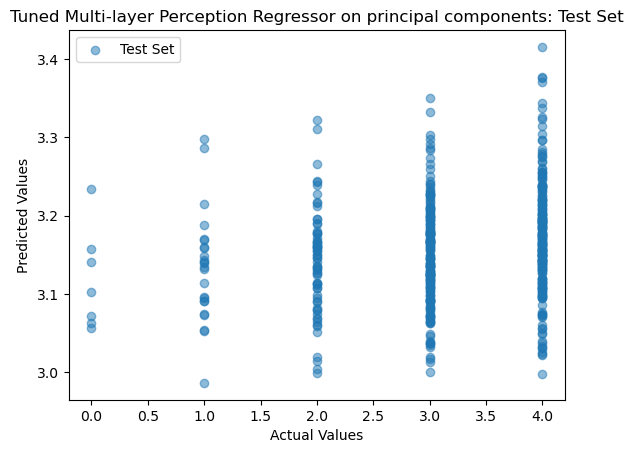

In [156]:
# Scatter plot for test set
plot_scatter(pca_y_test, pca_y_test_pred, 'Tuned Multi-layer Perception Regressor on principal components: Test Set')

In [157]:
# Retain results on test subset with default mlp model
result = evaluate_mlp_performance(mlp2, 'Tuned Multi-layer Perception Regressor on principal components', pca_X_test_scaled, 'Test Subset', pca_y_test)
pca_mlp_results_df = pd.concat([pca_mlp_results_df, result], ignore_index=True)
pca_mlp_results_df

,Model,Feature_Matrix,hidden_layer_sizes,Learning Rate,Activation,Alpha,Max_iter,MSE,MAE,R2,Explained Varience Score
0,Default Multi-layer Perception Regressor on pr...,Train Subset,"(100,)",constant,relu,0.0001,500,0.0184,0.0847,0.9791,0.9791
1,Default Multi-layer Perception Regressor on pr...,Validation Subset,"(100,)",constant,relu,0.0001,500,2.4321,1.1276,-1.7576,-1.7525
2,Tuned Multi-layer Perception Regressor on prin...,Train Subset,"(100,)",invscaling,logistic,10.0000,5000,0.8582,0.7224,0.0239,0.0240
3,Tuned Multi-layer Perception Regressor on prin...,Validation Subset,"(100,)",invscaling,logistic,10.0000,5000,0.8750,0.7323,0.0079,0.0081
4,Tuned Multi-layer Perception Regressor on prin...,Test Subset,"(100,)",constant,relu,0.0001,500,1.9727,1.0880,-1.2548,-1.2453


The model's performance metrics are relatively consistent across the Train, Validation, and Test Subsets. The model shows a decline in performance on the Test Subset, suggesting some challenges in generalizing to new, unseen data. Despite tuning, there seems to be some overfitting, particularly evident in the negative R2 and Explained Variance Score on the Test Subset.

Thus, the model Tuned MLPRegressor as trained and configured does not perform as well on the principall components in comparisson to the trained and configured MLPRegressor on the feature data.

# 9 Conclusions

**Model Performance Comparison**
Results for trained models on test subset (unseen data):

### Tuned Linear Regression:
        
| Evaluation Metrics      | Train Subset | Validation Subset | Test Subset |
|:------------------------|:-------------|:------------------|:-----------:|
|MSE                      | 0.8314       | 0.8940            | 0.8425      |
|MAE                      | 0.7103       | 0.7460            | 0.7152      |
|R2                       | 0.0544       | -0.0137           | 0.0369      |
|Explained Variance Score | 0.0544       | -0.0137           | 0.0371      |

### Default Random Forest Regressor:
        
| Evaluation Metrics      | Train Subset | Validation Subset | Test Subset |
|:------------------------|:-------------|:------------------|:-----------:|
|MSE                      | 0.1170       | 0.8697            | 0.8538      |
|MAE                      | 0.2688       | 0.7458            | 0.7307      |
|R2                       | 0.8669       | 0.0139            | 0.0241      |
|Explained Variance Score | 0.8672       | 0.0166            | 0.0278      |

### Default Gradient Boosting Regressor:
        
| Evaluation Metrics      | Train Subset | Validation Subset | Test Subset |
|:------------------------|:-------------|:------------------|:-----------:|
|MSE                      | 0.6116       | 0.8607            | 0.8708      |
|MAE                      | 0.6163       | 0.7266            | 0.7341      |
|R2                       | 0.3044       | 0.0241            | 0.0046      |
|Explained Variance Score | 0.3044       | 0.0243            | 0.0058      |

### Tuned Multi-layer Perception Regressor:
        
| Evaluation Metrics      | Train Subset | Validation Subset | Test Subset |
|:------------------------|:-------------|:------------------|:-----------:|
|MSE                      | 0.8487       | 0.8743            | 0.8446      |
|MAE                      | 0.7145       | 0.7314            | 0.7142      |
|R2                       | 0.0347       | 0.0086            | 0.0345      |
|Explained Variance Score | 0.0347       | 0.0086            | 0.0346      |


The Linear Regression model struggles to cature the complexity of the relationship between the predictors and the likeness rating.

The Random Forest Regressor offers good performance on the training subset but has a noticeable drop in R2 on the validation and test subsets, indicating potential overfitting.

The Gradient Boosting Regressor shows higher R2 on the training subset but struggles to generalise, resulting in lower R2 on the validation and test subsets.

The Multi-layer Perception Regressor demonstrates competitive performance across subsets, showing consistent results.

Thus, the **Tuned Multi-layer Perception Regressor** seems to perform best among the models.

### Further considerations for improvement involve:

- Explore additional feature engineering techniques to create new meaningful features or transformations that could enhance the model's ability to capture patterns in the data.
- Identify and handle outliers in the dataset. Outliers can significantly impact the performance of regression models. Consider using robust techniques or removing outliers strategically.
- Implement more advanced cross-validation strategies to ensure consistent model performance across different data subsets.
- Continue hyperparameter tuning, expanding the search space and trying different combinations of hyperparameters.
- utilise techniques like SHAP (SHapley Additive exPlanations) values to interpret complex models
- Conduct a detailed analysis of residuals (difference between predicted and actual values) to identify patterns or systematic errors 
- Consider data augmentation techniques. Data augmentation involves creating new training examples through random transformations of existing data.
- Explore post-processing techniques to refine model predictions, such as threshold optimisation or calibration methods.